#### Load needed modules
Here we load the needed python modules for using this notebook

In [1]:
# Import the needed Modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import numpy as np
import datetime
import pathlib
import math

#### Make presettings for plotting
We make use of the matplotlib rcParams, with which we can define the default settings for plotting. Here we define the default extension for exporting the plots. If this is changed all plots, if not otherwise specified, use this extension. 

In [2]:
# Set Default values for plotting
default_picture_extension = 'png'
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['savefig.format'] = default_picture_extension

##### Backup of Data
This function saves the given data as local backup using the current timestamp as name.

In [3]:
# makes a backup of the data given either as csv or excel file
def make_backup(data, format='excel'):
    '''
    Saves the given dataframe as a backup in the backups folder.
    The backup will be saved as excel or csv file.
    The name of the backup will be 'backup_YYYY-MM-DD_HHMMSS.xlsx/csv'
    :param data: The dataframe to be saved as backup
    :param format: The format of the backup. Either 'excel' or 'csv'
    '''

    # Get the current timestamp in the Format YYYY-MM-DD_HHMMSS
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")

    # Create the backups folder if it does not exist
    pathlib.Path('backups').mkdir(parents=True, exist_ok=True)
    
    # Save the analysis_df as excel file
    if format == 'excel':
        data.to_excel(f'backups/backup_{timestamp}.xlsx', index=False)
    
    # Save the analysis_df as excel file
    elif format == 'csv':       
        data.to_csv(f'backups/backup_{timestamp}.csv', index=False)

#### 1. Load the Data from the Google Spreadsheet

We directly obtain the data from the Google Spreadsheet. Therefore we make use of the URLand the pandas.read_csv() function is used. Hereby the worksheet is identified by an ID (gid), which can be seen in the URL when accessing the google document.



In [4]:
# Import Data from the spreadsheet
url_analysis = f'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=0&format=csv'
url_reference = f'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=1903780682&format=csv'
url_scenarios = f'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=300138599&format=csv'
url_sectors = 'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=2053313174&format=csv'
url_additional_parameters = 'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=855869427&format=csv'

# Load data from Sheet Scenario Analysis
analysis_df = pd.read_csv(url_analysis, usecols=np.arange(0,16))
analysis_df['Value'] = pd.to_numeric(analysis_df['Value'], errors='coerce')
analysis_df['Year'] = pd.to_numeric(analysis_df['Year'], errors='coerce')
analysis_df['Source'] = analysis_df['Source'].str.strip()
analysis_df['Scenario (name/historic/DLS)'] = analysis_df['Scenario (name/historic/DLS)'].str.strip()

# Make a backup of the analysis_df
make_backup(analysis_df, 'excel')

# Labelling and sorting of Scenarios
scenarios_df = pd.read_csv(url_scenarios)
scenarios_df['scenarios'] = scenarios_df['scenarios'].str.strip()
scenarios_df['scope'] = scenarios_df['scope'].str.strip()
scenarios_df['Source'] = scenarios_df['Source'].str.strip()

# Load data from Sheet Reference Values. Needed for Scenario names
reference_values_df = pd.read_csv(url_reference, header=[2])
reference_values_df = reference_values_df.iloc[3:22]
reference_values_df.columns.values[1:3] = ['Scenario', 'Country']

# Load data on Sectors (Which indicator is in which sector)
sectors_df = pd.read_csv(url_sectors, header=[1]).iloc[0:12]

# Load the data for additional_parameters
additional_params_df = pd.read_csv(url_additional_parameters, usecols=np.arange(0,14)).dropna(how='all')
additional_params_df = additional_params_df[additional_params_df['Coding'] == 1].copy()

#### 2. Preprocessing

#### 2.1 Define Color Schemes

We define colors for different use cases, e.g. for the sectors. Furthermore we have a Dictionary for the order of the sectors. We use thes Dictionaries for mapping.

In [19]:
# Define Color schemes
colors_sector = {
    'Energy': '#a62639',
    'Industry': '#73686a',
    'Buildings': '#28249e', 
    'Mobility': '#b5711d',
    'Freight': '#6e4615',
    'Food': '#216e15'
}

# Define the color scheme for the studies
colors_studies = {
    'historic': '#8496fa',
    'scenario 2045/50': '#132794',
    'other regions/approaches historic': '#d4d4d4',
    'other regions/approaches': 'grey'
}

# Define Colors per Scope
colors_traffic = {
    'historic': {
        'includes international': '#edba8a',  
        'inland': '#8496fa',
        'without active': '#9e575e',
        'without flights': '#425742',
        
    },
    'scenario 2045/50': {
        'includes international': '#f58d2c',   
        'inland': '#132794',
        'without active': '#9e0e1d',
        'without flights': '#083808',
           
    },
    'other regions/approaches historic': '#d4d4d4',
    'other regions/approaches': 'grey'
}

# Define Order
order_sectors = {
    'Energy': 0,
    'Industry': 1,
    'Buildings': 4, 
    'Mobility': 3,
    'Freight': 2,
    'Food': 5
}

# Define main comparison parameters that could include international
mobility_parameters = [
    'average distance travelled per capita and year',
    'average distance travelled per capita and year | plane',
    'average distance travelled per capita and year | car',
    'transported goods per capita and year',
]

#### 2.2 Define functions for processing data

First we define functions which are used for processing the data. The function hereby are __get_standard_scenarios__, __get_historic_data__ and __get_main_indicators__.

In [6]:
def get_standard_scenarios(raw_data, standard_scenarios_data):
    '''
    Function to get the standard scenarios from the raw data (Scenarios defined in the scenarios_final sheet)
    :param raw_data: Data from the Scenario Analysis sheet
    :param scenario_data: Data from the scenarios_final sheet
    :return: Dataframe with only the standard scenarios
    '''
    # Filter for the Coding == 1
    analysis_standard_df = raw_data[raw_data['Coding'] == 1].copy()

    # Remove Whitespaces and - out of the Geographic Scope column to have an consistent writing
    analysis_standard_df['Geographic scope'] = analysis_standard_df['Geographic scope'].str.replace(' ', '').str.replace('-', '')
    
    # Filter for standard scenarios
    standard_scenarios = standard_scenarios_data[standard_scenarios_data['standard'] == 1]

    # Get the indices of all data that belongs to the standard scenarios. Filter after Source, Scope and Scenario
    standard_scenarios_indices = standard_scenarios.apply(lambda x: analysis_standard_df[(analysis_standard_df['Source'] == x['Source']) 
                                                                                            & (analysis_standard_df['Geographic scope'] == x['scope']) 
                                                                                            & (analysis_standard_df['Scenario (name/historic/DLS)'] == x['scenarios'])].index.values, axis=1).explode().dropna()
    # Use the indices to select the correct rows from the data
    analysis_standard_df = analysis_standard_df.loc[standard_scenarios_indices]

    # Filter out kcal data for food waste and for food consumption use only data in kcal
    analysis_standard_df = analysis_standard_df[~((analysis_standard_df['Main comparison parameter'] == 'food waste per capita and year') & \
                (analysis_standard_df['Unit'].str.contains('kcal')))].copy()
    analysis_standard_df = analysis_standard_df[~((analysis_standard_df['Main comparison parameter'] == 'meat consumption per capita and day') & \
                (analysis_standard_df['Unit'].str.contains('kg')))].copy()
    
    # Return the filtered dataframe
    return analysis_standard_df

In [7]:
def get_historic_data(raw_data, indicator=False):
    '''
    Function to get the historic data from the raw data.
    :param raw_data: Data from the Scenario Analysis sheet
    :param indicator: Indicator to filter after
    :return: Dataframe with only the historic data
    '''
    # Filter for the Coding == 1
    historic_data = raw_data[raw_data['Coding'] == 1].copy()

    # Remove Whitespaces and - out of the Geographic Scope column to have an consistent writing
    historic_data['Geographic scope'] = historic_data['Geographic scope'].str.replace(' ', '').str.replace('-', '')
    
    # Cheange type of year to numeric
    historic_data['Year'] = pd.to_numeric(historic_data['Year'], errors='coerce')

    # Filter for historic scenario
    historic_data = historic_data[(historic_data['Scenario (name/historic/DLS)'] == 'historic') | (historic_data['Year'] < 2045)]

    # Filter out kcal data for food waste and for food consumption use only data in kcal
    historic_data = historic_data[~((historic_data['Main comparison parameter'] == 'food waste per capita and year') & \
                (historic_data['Unit'].str.contains('kcal')))].copy()
    historic_data = historic_data[~((historic_data['Main comparison parameter'] == 'meat consumption per capita and day') & \
                (historic_data['Unit'].str.contains('kg')))].copy()
    
    # If an main indicator is given, filter also after that
    if indicator:
        historic_data = historic_data[historic_data['Main comparison parameter'] == indicator]
    
    # Return the filtered dataframe
    return historic_data

In [15]:
def get_main_indicators(data, split=False):
    '''
    Function to get the main indicators from the data.
    :param data: Data from the Scenario Analysis sheet
    :return: List of the main indicators
    '''
    # Get the main indicators out of the data
    main_indicators = data['Main comparison parameter'].dropna().unique()

    if split:
        # Split the main indicators into Mobilit and Non Mobility
        main_indicators_mobility = [indicator for indicator in main_indicators if indicator in mobility_parameters]
        main_indicators_non_mobility = [indicator for indicator in main_indicators if indicator not in mobility_parameters]
        main_indicators = [main_indicators_mobility, main_indicators_non_mobility]
    return main_indicators

In [9]:
# Make the Anzahl Reference Values Table
historic_data = get_historic_data(analysis_df)
historic_data['Anzahl'] = 1
historic_data = historic_data.groupby(['Main comparison parameter', 'Geographic scope']).sum().reset_index()
historic_data['Indicator'] = historic_data['Main comparison parameter']
historic_data['Scope'] = historic_data['Geographic scope']
historic_data = historic_data[['Indicator', 'Scope', 'Anzahl']]
historic_data = historic_data.set_index(['Indicator', 'Scope'])
historic_data = historic_data.unstack()
historic_data.to_excel('output/Anzahl_Reference.xlsx')


### 3. Analysis
In the following we analyse the data and make different plots. Hereby for each plot we define a function, so we can reuse the process for applying it to germany.

#### 3.1 Europe/World
At first we set our scope to Europe/World, which also includes studies only having one country as a scope. Hereby we make barplots, boxplots and a scatter diagram.

##### 3.1.1 Barplot Occurences
We count for each main indicator how many times there is a study for it.

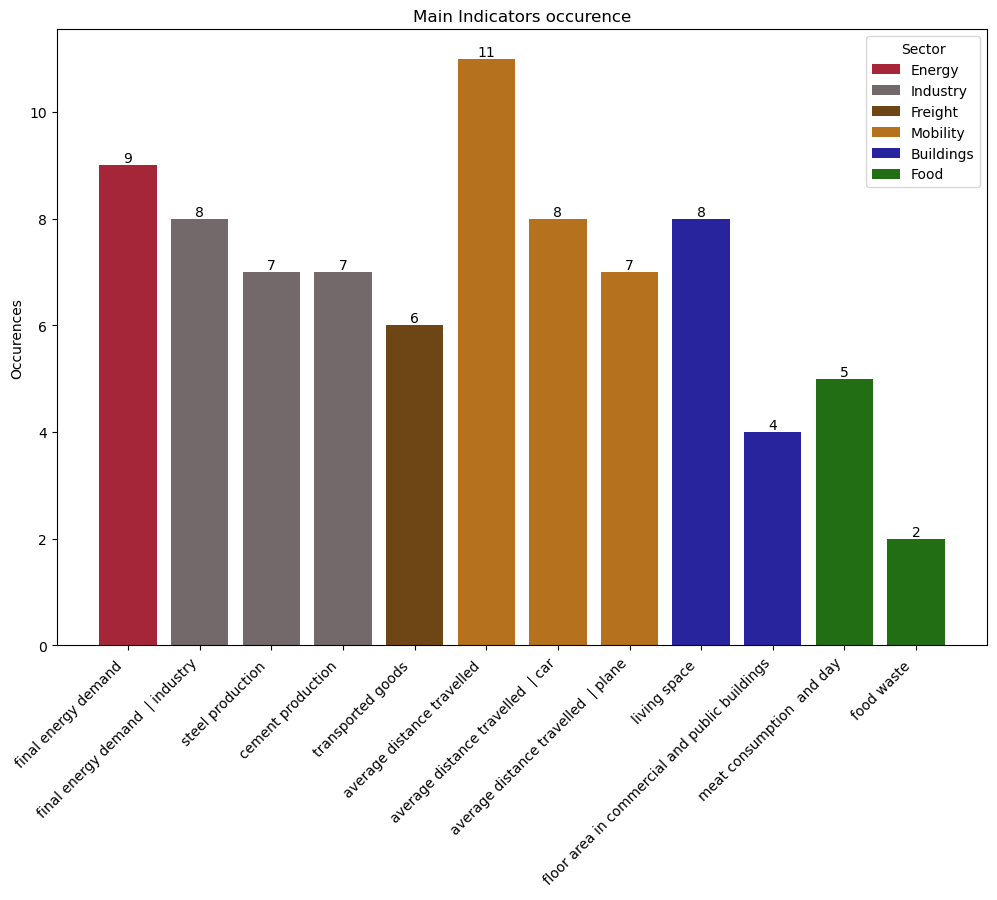

In [10]:
# Define it as a function to make it reusable
def make_barplot_occurences(data, filename, extension=False, standard=False):
    '''
    Function to make a barplot of the occurences of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data

    # Get the main indicators excluding the mobility ones
    main_indicators = get_main_indicators(analysis_standard_df)

    # Get counts per Main Indicator
    main_indicator_count = analysis_standard_df['Main comparison parameter'].value_counts()

    # Create Dataframe for plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Occurences', 'Sector', 'Color'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Occurences'] = main_indicators_plotting_df['Indicator']\
                                                    .apply(lambda x: main_indicator_count.loc[x])
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator']\
                                                    .apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector']\
                                                    .values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector']\
                                                    .apply(lambda x: colors_sector[x])
    main_indicators_plotting_df['Order'] =  main_indicators_plotting_df['Sector'].apply(lambda x: order_sectors[x])

    # Sort the Values by the Order and the Occurences
    main_indicators_plotting_df = main_indicators_plotting_df\
                                    .sort_values(by=['Order', 'Occurences'], ascending=[True, False])

    # Make a bar plot
    fig, ax = plt.subplots(1)
    bar = ax.bar(main_indicators_plotting_df['Indicator'].values, 
                main_indicators_plotting_df['Occurences'].values, 
                label=main_indicators_plotting_df['Sector'].values, 
                color=main_indicators_plotting_df['Color'].values)
    
    # Configure the plot
    ax.set_title('Main Indicators occurence')
    ax.set_ylabel('Occurences')
    ax.bar_label(bar)
    
    # Remove the per capita out of the naming to save space
    main_indicators_x_axis_naming = [s.replace('per capita and year', '')\
                                     .replace('per capita', '') for s in main_indicators_plotting_df['Indicator'].values] 
    
    # Set the xticks
    ax.set_xticks(np.arange(len(main_indicators_plotting_df['Indicator'].values)), 
                labels=main_indicators_x_axis_naming, 
                rotation=45, 
                ha="right")
    
    # Get the correct legend without duplicate keys
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title='Sector', loc='upper right')

    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")

# Call function. Extension can be set to png, eps, pdf. If nothing given the Extension defined above as default is used
make_barplot_occurences(analysis_df, 'barplot_occurences')

##### 3.1.2 Value per Main Indicator

Show the different value of one indicator for different scenarios. Therefore make a plot per indicator and show as a bar plot the values per scenario.


In [11]:
def get_historic_values(raw_data, indicator_data, indicator):
    '''
    Function to assign each study for the current indicator the historic value.
    :param raw_data: Data from the Scenario Analysis sheet
    :param indicator_data: Data for the indicator
    :param indicator: Indicator to filter after
    :return: indicator_data with the added historic values
    '''
    # Get the historic data for the current indicator
    # Shortened the variable name for readability
    h_df = get_historic_data(raw_data, indicator)

    # Get data from additional parameters
    additional_params_indicator = additional_params_df[(additional_params_df['Main comparison parameter'] == indicator) & \
                                                       (additional_params_df['Scenario (name/historic/DLS)'] == 'historic')]

    # Iterate over the rows in the indicator data (meaning iterating over the scenarios)
    # Search for a historic value for each scenario
    for index, row in indicator_data.iterrows():
        
        # Get the scenario name and Scope
        scenario = row['Source']
        scope = row['Geographic scope']

        # Get only data with the same scope
        scope_data = h_df[h_df['Geographic scope'] == scope]

        # Check if a historic value for négaWatt is available
        if len(scope_data[scope_data['Source'] == 'négaWatt et al. (2023)']) != 0:
            historic_value = scope_data[scope_data['Source'] == 'négaWatt et al. (2023)']['Value'].values[0]
            historic_parameter = scope_data[scope_data['Source'] == 'négaWatt et al. (2023)']['Parameter'].values[0]
            source = 'négaWatt et al. (2023)'
        
        # Else check if a historic value in the additional data is available
        elif len(additional_params_indicator) != 0:
            historic_value = additional_params_indicator['value'].values[0]
            historic_parameter = additional_params_indicator['Parameter'].values[0]
            source = additional_params_indicator['Source'].values[0]
        
        # Else check if a historic value of the scenario is available
        elif len(scope_data[scope_data['Source'] == scenario]) != 0:
            historic_value = scope_data[scope_data['Source'] == scenario]['Value'].values[0]
            historic_parameter = scope_data[scope_data['Source'] == scenario]['Parameter'].values[0]
            source = scenario
        
        # Otherwise check if a historic value of the scope is available
        elif len(scope_data) != 0:
            historic_value = scope_data['Value'].values[0]
            historic_parameter = scope_data['Parameter'].values[0]
            source = scope_data['Source'].values[0]
        
        # Otherwise no historic value is available
        else:
            historic_value = np.nan
            historic_parameter = np.nan
            source = np.nan

        # Set the historic value in the indicator data
        indicator_data.at[index, 'Historic'] = historic_value

        # Add the source of the historic value
        indicator_data.at[index, 'Historic Source'] = source

        # Add the Parameter of the Historic source
        indicator_data.at[index, 'Historic Parameter'] = historic_parameter

    # Return the changed dataframe with the historic values
    return indicator_data

In [12]:
def get_additional_data(raw_data, indicator, sources):
    '''
    Function to get additional data for the given indicator and the given sources
    :param raw_data: Data from the Scenario Analysis sheet
    :param indicator: Indicator to filter after
    :param sources: Sources to filter after (Sources of the additional data)
    :return: Dataframe with the additional data
    '''
    # Create empty dataframe
    add_data = pd.DataFrame(columns=['Source', 'Source+geogr. scope', 'Geographic scope' , 
                                     'Value', 'Year', 
                                     'Scenario (name/historic/DLS)', 
                                     'Historic', 'International', 
                                     'International Historic', 'Parameter', 'Main comparison parameter'])

    # Get data for Gruber et. al and Hilward, Hopkins et al., etc.
    for source in sources:

        # Get the data for the source and the indicator and filter for coding == 1
        source_data_raw = raw_data[(raw_data['Source'] == source)
                            & (raw_data['Main comparison parameter'] == indicator)
                            & (raw_data['Coding'] == 1)].copy()
        
        # Get only the NOT historic data
        source_data = source_data_raw[(source_data_raw['Scenario (name/historic/DLS)'] != 'historic') & (source_data_raw['Year'] >= 2045)]
        
        # Sort the values from low to high
        source_data = source_data.sort_values(by=['Value'], ascending=False)
        
        # Concat the filtered data to the dataframe used to store all additional data
        add_data = pd.concat([add_data, source_data], join='inner', ignore_index=True)

    # Get the historic values for the additional data and the indicator (same as for the standard scenarios)
    add_data = get_historic_values(raw_data, add_data, indicator)

    # Drop the column Year as it is not needed anymore
    add_data = add_data.drop(columns=['Year'])
    
    # Return the dataframe with the additional data
    return add_data 

In [13]:
def plot_traffic_bars(ax, data, label, value_column_name, group_column_name, parameter_column_name):
    '''
    Function to plot the traffic bars for the given data
    :param ax: Axis to plot on
    :param data: Data to plot
    :param label: Label of the data (historic or scenario)
    :param value_column_name: Name of the column with the values
    :param group_column_name: Name of the column with the groups
    :param parameter_column_name: Name of the column with the parameters
    :return: Axis with the plotted data
    '''
    # Initialize y_set_list for stacked bar chart
    #y_set_list = list(np.zeros(len(data)))

    # check if the label is historic or scenario
    if label == 'historic':
        x_shift = -0.2
    else:
        x_shift = 0.2
    
    # Loop over the groups (inland, international, without active, with flights)
    for group in colors_traffic[label].keys():

        # Get all data for the current group
        group_data = data[data[group_column_name] == group].copy()

        # Check if the group is empty
        if len(group_data) == 0:
            continue

        # Get the y_set for the current group
        #y_set_group = [y_set_list[i] for i in group_data['x_position'].values]
        
        # Plot the scenario values
        bars = ax.bar(group_data['x_position'].values + x_shift,  
                                group_data[value_column_name].values,
                                #bottom=y_set_group,
                                width = 0.4,
                                facecolor = colors_traffic[label][group],
                                label=label)
        
        # Make plots containing no active modes hatched
        # group_data = group_data.reset_index()
        # for i, row in group_data.iterrows():
        #     if 'without active' in row[parameter_column_name]:
        #         bars[i].set_hatch('///')
        #         bars[i].set_edgecolor('black')

        # update y_set list for stacked bar chart
        # for i, y_set in enumerate(y_set_list):
        #     if i in group_data['x_position'].values:
        #         y_set += group_data[group_data['x_position'] == i]['Value'].values[0]
        #         y_set_list[i] = y_set
    
    # If a value is zero, write a zero next to the bar
    for zero_index in data[data[value_column_name] == 0].index.values:
            ax.text(zero_index + 0.2, 0.5, '0', ha='center', va='bottom')

    # Return the axis
    return ax

C:\Users\yanni\AppData\Local\Temp\ipykernel_28704\4020170066.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'négaWatt et al. (2023)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  indicator_data.at[index, 'Historic Source'] = source
C:\Users\yanni\AppData\Local\Temp\ipykernel_28704\4020170066.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Passenger km per capita on road' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  indicator_data.at[index, 'Historic Parameter'] = historic_parameter
C:\Users\yanni\AppData\Local\Temp\ipykernel_28704\2733132056.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result 

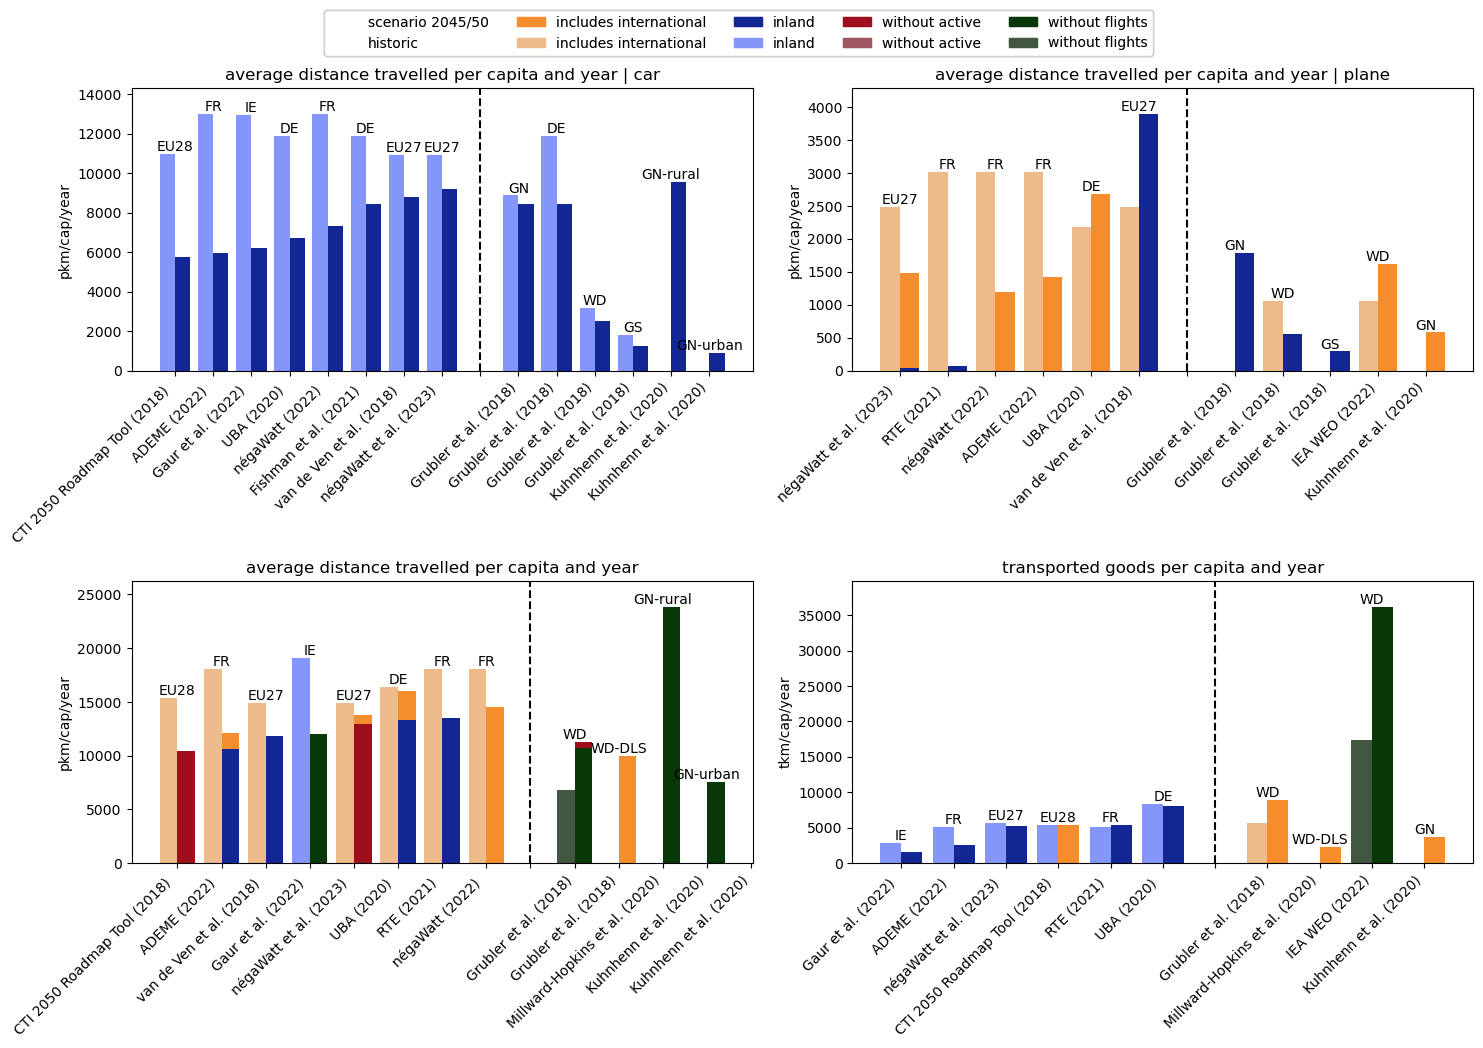

In [48]:
def make_traffic_plots(data, filename, extension = False, standard=False,
                          show_extra_bars = True, show_scope = True, 
                          plot_individual = False, show_historic = True):
    '''
    Function to make the traffic plots
    :param ax: Axis to plot on
    :param indicator: Indicator to plot
    :param indicator_data: Data for the indicator
    :param data: Data from the Scenario Analysis sheet
    :param show_historic: Boolean if the historic values should be shown
    :param show_scope: Boolean if the scope should be shown
    :param show_extra_bars: Boolean if the extra bars should be shown
    :return: Axis with the plot
    '''
    # Check for the boolean standard, which indicates if the given data is already 
    # filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data

    # Get the main indicators including only the mobility ones
    main_indicators = get_main_indicators(analysis_standard_df, split = True)[0]

    # Check if the plot should be saved as individual plots
    if not plot_individual:
    
        # Define number of columns for the subplots
        cols = 2
        rows = int(math.ceil((len(main_indicators) / cols)))

        # Create a figure of subplots
        fig, axs = plt.subplots(rows, cols, figsize=(15,10))

    # Create Dataframe for exporting the data as excel file
    export_df = pd.DataFrame()
    
    # Iterate over the indicators and make a plot for each índicator
    for i, indicator in enumerate(main_indicators):

        # Check if the plot should be saved as individual plots. If not create a single plot
        if plot_individual:
            fig, ax = plt.subplots(1)
        
        # Otherwise select the correct subplot
        else:
            # Calculate current row and column 
            row = i // cols
            col = i % cols
            ax = axs[row, col]

        # Get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator]\
                            .copy().reset_index()
        
        # Select only the needed columns
        indicator_data = indicator_data[['Source', 
                                         'Source+geogr. scope',
                                         'Geographic scope', 
                                         'Scenario (name/historic/DLS)', 
                                         'Sector',
                                         'Main comparison parameter',
                                         'Parameter',
                                         'Unit',
                                         'Value']]
        indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
        # indicator_data['Color'] = indicator_data['Geographic scope']\
        #                             .apply(lambda x: color[x] if x in scope_colors.keys() else scope_colors['single'])
        # indicator_data['Label'] = indicator_data['Geographic scope']\
        #                             .apply(lambda x: x if x in scope_colors.keys() else 'single')
        indicator_data.loc[:, 'Historic'] = np.nan

        # Add a column to identify the additional data
        indicator_data.loc[:, 'Additional Data'] = False

        # Get the groups for the current indicator (default is inland)
        indicator_data['Group'] = 'inland'
        indicator_data.loc[indicator_data['Parameter'].str.contains('international'), 'Group'] = 'includes international'
        indicator_data.loc[indicator_data['Parameter'].str.contains('without active'), 'Group'] = 'without active'
        indicator_data.loc[indicator_data['Parameter'].str.contains('without flights'), 'Group'] = 'without flights'

        # Sort the data by the value (From lowest to highest)
        indicator_data = indicator_data.sort_values('Value').reset_index()

        # Get the historic data for the current indicator and each scenario
        indicator_data = get_historic_values(analysis_df, indicator_data, indicator)

        # Get thr groups for the historic data (default is inland)
        indicator_data['Historic Group'] = 'inland'
        indicator_data.loc[indicator_data['Historic Parameter'].str.contains('international'), 'Historic Group'] = 'includes international'
        indicator_data.loc[indicator_data['Historic Parameter'].str.contains('without active'), 'Historic Group'] = 'without active'
        indicator_data.loc[indicator_data['Historic Parameter'].str.contains('without flights'), 'Historic Group'] = 'without flights'
        
        # Export the data as excel file if wanted
        if i == 0:
            export_df = indicator_data.copy()
        else:
            export_df = pd.concat([export_df, indicator_data], ignore_index=True)

        # Get unique sources for the x-axis
        scenario_sources = list(indicator_data['Source+geogr. scope'].unique())

        # Assign each unique source a x-position (needed for stacked plots)
        indicator_data['x_position'] = indicator_data['Source+geogr. scope'].apply(lambda x: scenario_sources.index(x))

        # Plot the scenario values
        ax = plot_traffic_bars(ax, indicator_data, 'scenario 2045/50', 'Value', 'Group', 'Parameter')

        # If wanted plot also the historic values as bars
        if show_historic:    
            ax = plot_traffic_bars(ax, indicator_data, 'historic', 'Historic', 'Historic Group', 'Historic Parameter')

        # Else plot historic line
        else:
            line_hist = ax.axhline(y=indicator_data['Historic'].values[0], 
                                    color='black', linestyle='--', 
                                    label='historic') 
        
        # If the Scope should be shone (Not for Germany only plots), write the scope over each bar
        if show_scope:

            # Get the maximum values for each x-position
            max_values_scenarios = indicator_data.groupby('x_position', as_index=False).agg({'Value':'max', 
                                                                                   'Historic':'max', 
                                                                                   'Geographic scope':'first'}).copy()
            # Place the Scope over each bar
            for i, row in max_values_scenarios.iterrows():
                ax.text(row['x_position'], max(row['Value'], row['Historic']), row['Geographic scope'], ha='center', va='bottom')

        # Get the naming for the x-ticks. Need to be the source without the scope
        x_ticks = [scenario_sources.split('-')[0] for scenario_sources in scenario_sources]
        
        # If the extra bars should be shown get the data for the extra bars
        if show_extra_bars:

            # Define Sources for the additional data
            sources_add =  ['Grubler et al. (2018)', 
                        'Millward-Hopkins et al. (2020)', 
                        'IEA WEO (2022)', 
                        'Kuhnhenn et al. (2020)']
            
            # Get the additional data
            add_data = get_additional_data(data, indicator, sources_add)

            # Assign the groups for the additional data (default is inland)
            add_data['Group'] = 'inland'
            add_data.loc[add_data['Parameter'].str.contains('international'), 'Group'] = 'includes international'
            add_data.loc[add_data['Parameter'].str.contains('without active'), 'Group'] = 'without active'
            add_data.loc[add_data['Parameter'].str.contains('without flights'), 'Group'] = 'without flights'

            # Assign the groups for the historic additional data (default is inland)
            add_data['Historic Group'] = 'inland'
            add_data.loc[add_data['Historic Parameter'].str.contains('international', na=False), 'Historic Group'] = 'includes international'
            add_data.loc[add_data['Historic Parameter'].str.contains('without active', na=False), 'Historic Group'] = 'without active'
            add_data.loc[add_data['Historic Parameter'].str.contains('without flights', na=False), 'Historic Group'] = 'without flights'

            # Make a vertical line to seperate the extra plots. Therefor append an empty string to the x_ticks
            x_ticks.append('')
            x_offset = len(x_ticks) - 1
            ax.axvline(x_offset, color='#030303', linestyle='--')
            x_offset += 1

            # Get unique sources for the x-axis
            add_data_sources = list(add_data['Source+geogr. scope'].unique())

            # Assign each unique source a x-position (needed for stacked plots)
            add_data['x_position'] = add_data['Source+geogr. scope'].apply(lambda x: x_offset + add_data_sources.index(x))

            # Add the additional data to the export dataframe
            export_df = pd.concat([export_df, add_data], ignore_index=True)

            # Plot the scenario values of the additional data
            ax = plot_traffic_bars(ax, add_data, 'scenario 2045/50', 'Value', 'Group', 'Parameter')

            # Plot the historic values of the additional data
            if show_historic:    
                ax = plot_traffic_bars(ax, add_data, 'historic', 'Historic', 'Historic Group', 'Historic Parameter')
            
            # Get the y position for the scope
            max_values_add = add_data.groupby('x_position', as_index=False).agg({'Value':'max', 
                                                                                   'Historic':'max', 
                                                                                   'Geographic scope':'first'}).copy()
            # Place the Scope over each bar
            for i, row in max_values_add.iterrows():
                ax.text(row['x_position'], max(row['Value'], row['Historic']), row['Geographic scope'], ha='center', va='bottom')
            
            # Add the sources to the x_ticks for labeling the x axis
            x_ticks += add_data['Source'].values.tolist()

            # Define the patches (Label, Color) for the legend
            patches_scenario = [mpatches.Patch(color=colors_traffic['scenario 2045/50'][x], label=x) for x in colors_traffic['scenario 2045/50'].keys()]
            patches_historic = [mpatches.Patch(color=colors_traffic['historic'][x], label=x) for x in colors_traffic['historic'].keys()]
            
            # Reorder the patches for the legend
            patches = [patches_scenario[i//2] if i % 2 == 0 else patches_historic[(i-1)//2] for i in range(2*len(patches_scenario))]
            
            # Insert empty patches as naming for the row of the legend
            patches.insert(0, (mpatches.Patch(color='white', label= 'scenario 2045/50')))
            patches.insert(1, (mpatches.Patch(color='white', label= 'historic')))

            # Add the Legend
            fig.legend(handles=patches, loc='upper center', ncols = 5, bbox_to_anchor = (0, 0.05, 1, 1))
                
        else:
            # Define the patches (Label, Color) for the legend
            patches_scenario = [mpatches.Patch(color=colors_traffic['scenario 2045/50'][x], label='scenario ' + x) for x in colors_traffic['scenario 2045/50'].keys()]
            patches_historic = [mpatches.Patch(color=colors_traffic['historic'][x], label='historic ' + x) for x in colors_traffic['historic'].keys()]
            
            # Reorder the patches for the legend
            patches = [patches_scenario[i//2] if i % 2 == 0 else patches_historic[(i-1)//2] for i in range(2*len(patches_scenario))]
            
            # Insert empty patches as naming for the row of the legend
            patches.insert(0, (mpatches.Patch(color='white', label= 'scenario 2045/50')))
            patches.insert(1, (mpatches.Patch(color='white', label= 'historic')))

            # Add the Legend
            fig.legend(handles=patches, loc='upper center', ncols = 5, bbox_to_anchor = (0, 0.05, 1, 1))

        # Configure plot
        ax.set_title(f'{indicator}')
        ax.set_ylabel(indicator_data['Unit'].values[0])
        ax.set_xticks(np.arange(len(x_ticks)),x_ticks, rotation=45, ha="right")

        # Get the maximum Value of the bar plot to set the limit a bit higher than the max value
        if show_scope:
            max_value = max(max_values_scenarios[['Value', 'Historic']].max(axis=1).max(), 
                            max_values_add[['Value', 'Historic']].max(axis=1).max())
        else:
            max_value = indicator_data[['Value', 'Historic']].max(axis=1).max()
        ax.set_ylim(0, max_value* 1.1)

    # If the plots should be saved as individual plots
    if plot_individual:
        
        # Save figure either with default extension or with extension given in the function
        if extension:
            filename = f'{filename}.{extension}'
        
        # Save the figure as png
        indicator_naming = indicator.replace('|', '')
        plt.savefig(f'figures/{filename}_{indicator_naming}', bbox_inches = "tight")

    # Make a nicer look
    plt.tight_layout()
    
    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    
    # Save the figure as png
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")
    
    # rearange columns for export
    export_df = export_df[['Source', 'Geographic scope', 
                        'Scenario (name/historic/DLS)', 
                        'Sector', 'Parameter', 'Main comparison parameter',
                        'Unit', 'Value', 'Historic',
                        'Historic Source', 'Additional Data', 
                        'Group', 'Historic Group']]

    # Export the data from the barplot
    export_df.to_excel(f'output/data_barplot_mobility.xlsx', index=False)

# Call function for making barplots
make_traffic_plots(analysis_df, 'barplot_values_traffic', plot_individual=False)

C:\Users\yanni\AppData\Local\Temp\ipykernel_28704\4020170066.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Climact (2024)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  indicator_data.at[index, 'Historic Source'] = source
C:\Users\yanni\AppData\Local\Temp\ipykernel_28704\4020170066.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'non-residential surface area per person' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  indicator_data.at[index, 'Historic Parameter'] = historic_parameter
C:\Users\yanni\AppData\Local\Temp\ipykernel_28704\2733132056.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result 

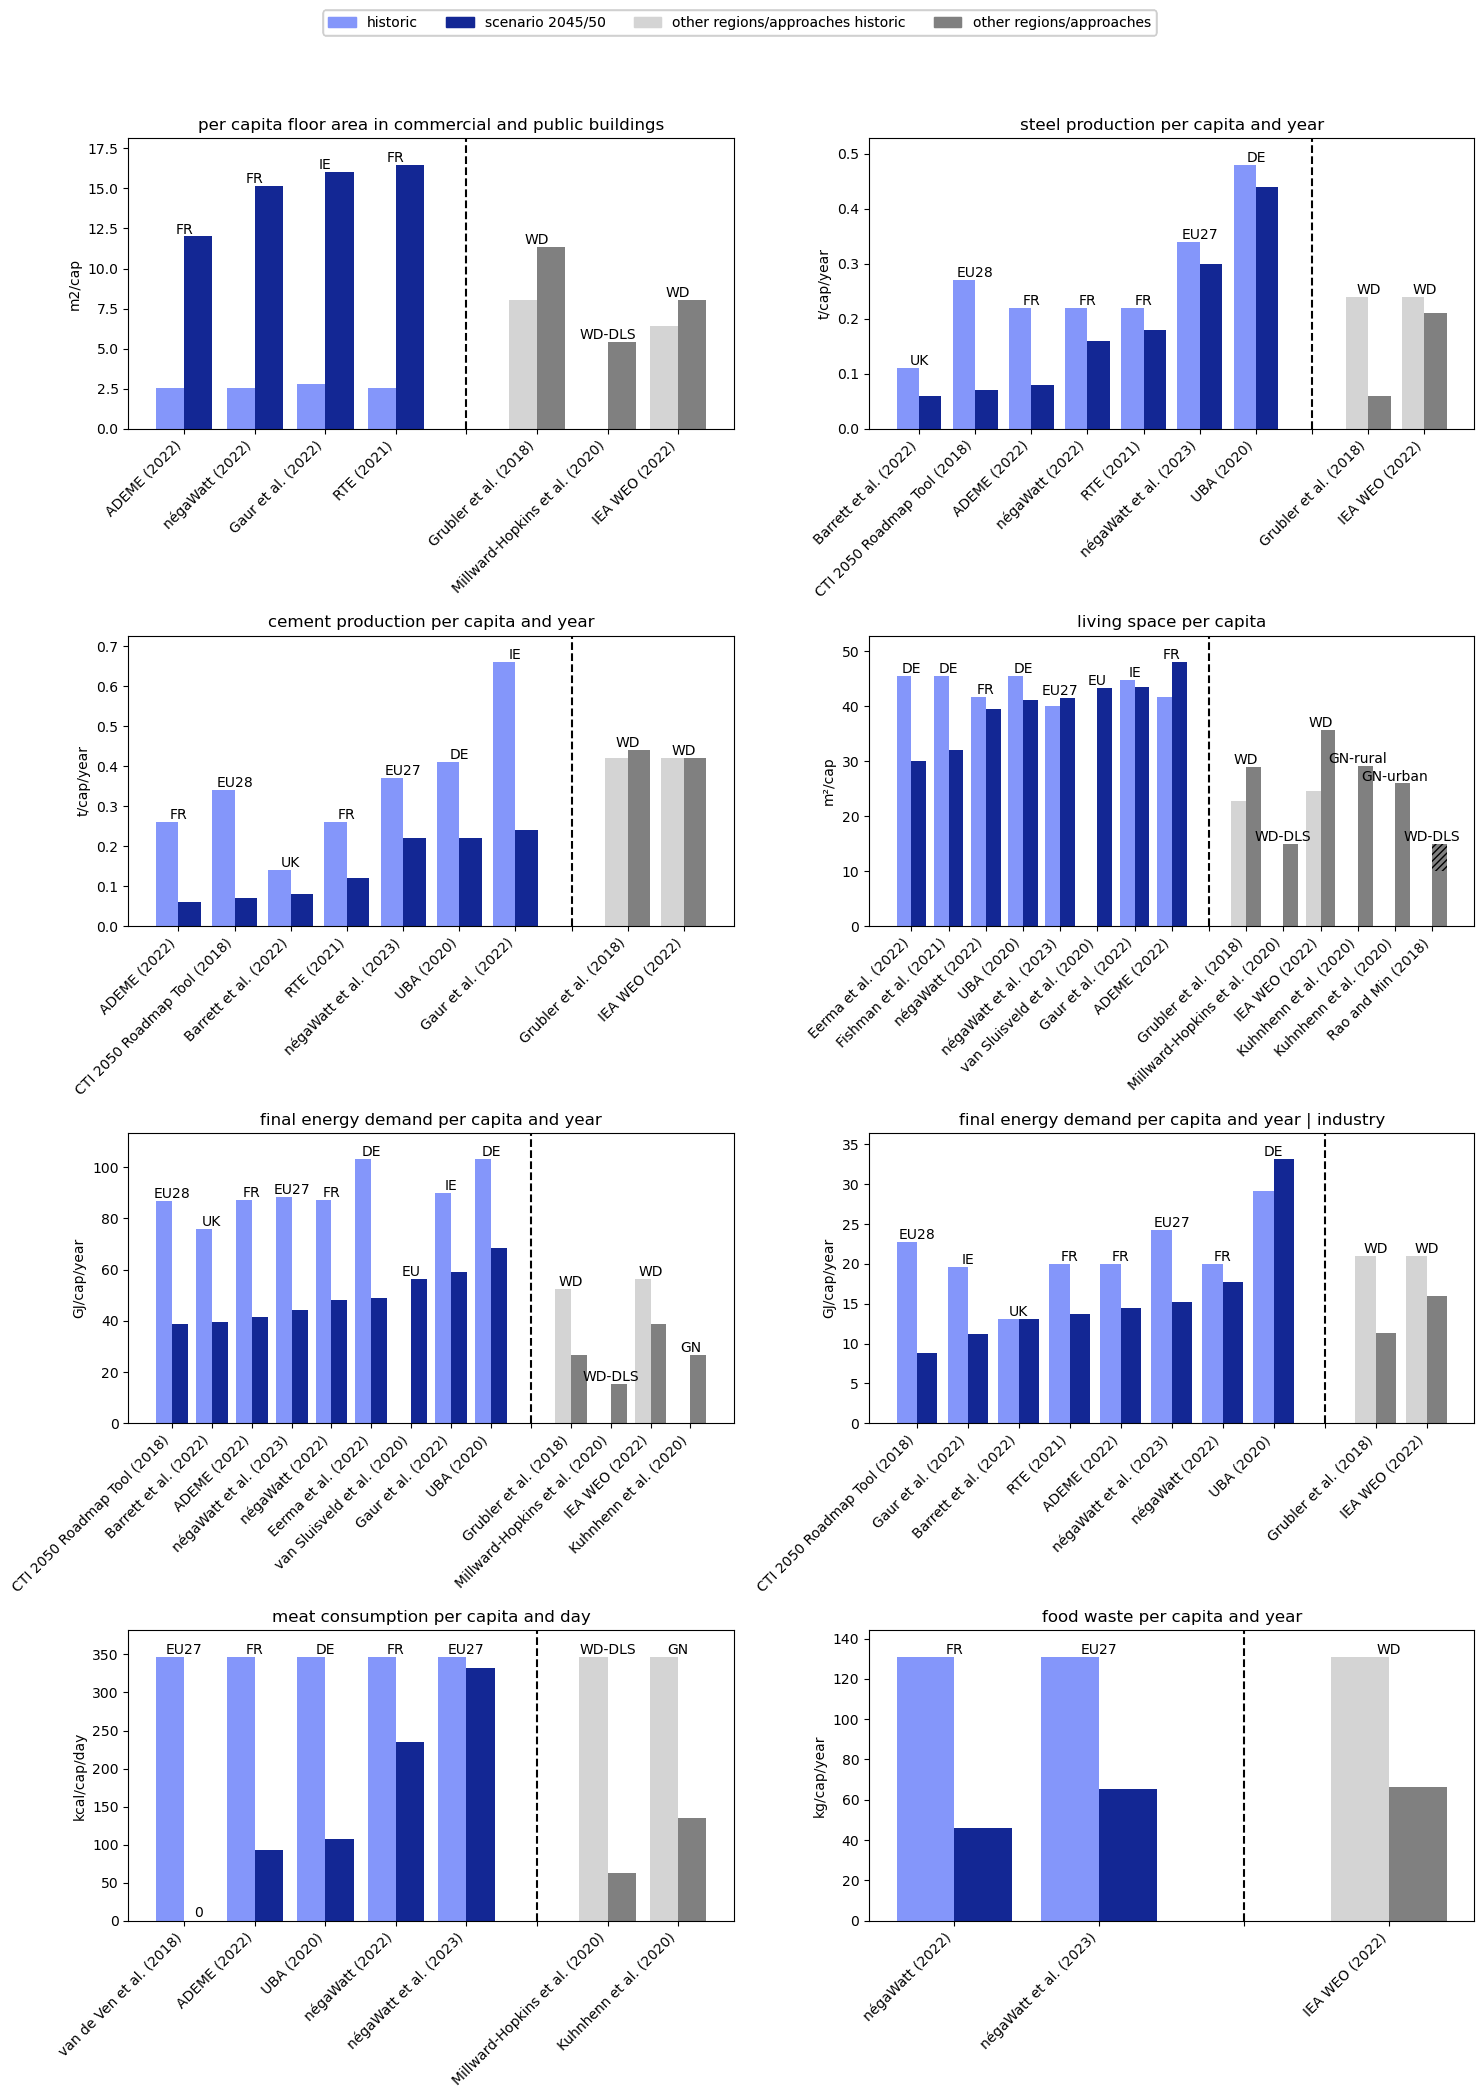

In [23]:
def make_barplot_multiple(data, filename, extension = False, standard=False,
                          show_extra_bars = True, show_scope = True, 
                          plot_individual = False, show_historic = True):
    '''
    Function to make a barplot of the values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :param show_extra_bars: Boolean if extra bars should be shown
    :param show_scope: Boolean if the scope should be shown
    :param plot_individual: Boolean if the plot should be saved as individual plots
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already 
    # filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data
    
    # Get the main indicators excluding the mobility ones
    main_indicators = get_main_indicators(analysis_standard_df, split = True)[1]

    # Check if the plot should be saved as individual plots
    if not plot_individual:
    
    # Define number of columns for the subplots
        cols = 2
        rows = int(math.ceil((len(main_indicators) / cols)))

        # Create a figure of subplots
        fig, axs = plt.subplots(rows, cols, figsize=(15,20))

    # Create Dataframe for exporting the data as excel file
    export_df = pd.DataFrame()
    # Iterate over the indicators and make a plot for each índicator
    for i, indicator in enumerate(main_indicators):

        # Check if the plot should be saved as individual plots. If not create a single plot
        if plot_individual:
            fig, ax = plt.subplots(1)
        else:
            # Calculate current row and column 
            row = i // cols
            col = i % cols
            ax = axs[row, col]

        # Get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator]\
                            .copy().reset_index()
        indicator_data = indicator_data[['Source', 
                                         'Geographic scope', 
                                         'Scenario (name/historic/DLS)', 
                                         'Sector',
                                         'Main comparison parameter',
                                         'Parameter',
                                         'Unit',
                                         'Value']]
        indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
        # indicator_data['Color'] = indicator_data['Geographic scope']\
        #                             .apply(lambda x: scope_colors[x] if x in scope_colors.keys() else scope_colors['single'])
        # indicator_data['Label'] = indicator_data['Geographic scope']\
        #                             .apply(lambda x: x if x in scope_colors.keys() else 'single')
        indicator_data['Historic'] = np.nan

        # Add a column to identify the additional data
        indicator_data['Additional Data'] = False

        # Sort the data by the value (From lowest to highest)
        indicator_data = indicator_data.sort_values('Value').reset_index()

        # Get the historic data for the current indicator and each scenario
        indicator_data = get_historic_values(analysis_df, indicator_data, indicator)
        
        # Export the data as excel file if wanted
        if i == 0:
            export_df = indicator_data.copy()
        else:
            export_df = pd.concat([export_df, indicator_data], ignore_index=True)

        # Get the x-positions for the bars
        x = np.arange(len(indicator_data))

        # Plot the scenario values
        bar_scenarios = ax.bar(x+0.2, 
                    indicator_data['Value'].values,
                    width = 0.4,
                    color = colors_studies['scenario 2045/50'],
                    label='scenario 2045/50')

        # Add a zero if scenario value is zero
        for zero_index in indicator_data[indicator_data['Value'] == 0].index.values:
            ax.text(zero_index + 0.2, 0.5, '0', ha='center', va='bottom')
        
        # If wanted plot also the historic values as bars
        if show_historic:            
            
            # Plot the historic values
            bar_hist = ax.bar(x-0.2, 
                        indicator_data['Historic'].values,
                        width = 0.4,
                        color = colors_studies['historic'],
                        label='historic')

            # Add a zero if historic value is zero
            for zero_index in indicator_data[indicator_data['Historic'] == 0].index.values:
                ax.text(zero_index - 0.2, 0.5, '0', ha='center', va='bottom')
        
        # Else plot historic line
        else:
            line_hist = ax.axhline(y=indicator_data['Historic'].values[0], 
                                   color='black', linestyle='--', 
                                   label='historic') 
        
        # If the Scope should be shone (Not for Germany only plots)
        if show_scope:

            # Write the scope for each scenario over the bars (Over the highest bar between historic and scenario value)
            for i, rect_scen in enumerate(bar_scenarios):

                # Check if historic values are shown, if yes get the higher bar between historic and scenario value
                if show_historic:
                    rect_hist = bar_hist[i]
                    height = max(rect_scen.get_height(), rect_hist.get_height())
                
                # If no historic values are shown get the height of the scenario value
                else:
                    height = rect_scen.get_height()
                
                # Get the scope of the scenario
                scope_study = indicator_data.iloc[i]['Geographic scope']
                
                # Write the scope over the bar
                ax.text(rect_scen.get_x(), height, scope_study, ha='center', va='bottom')

        # Get the naming for the x-ticks
        x_ticks = list(indicator_data['Source'].values)
        
        # If the extra bars should be shown get the data for the extra bars
        if show_extra_bars:

            # Get additional data
            sources =  ['Grubler et al. (2018)', 
                        'Millward-Hopkins et al. (2020)', 
                        'IEA WEO (2022)', 
                        'Kuhnhenn et al. (2020)',
                        'Rao and Min (2018)']
            
            # Get the additional data
            add_data = get_additional_data(data, indicator, sources)

            # Mark it as additional data
            add_data['Additional Data'] = True

            # Export the data as excel file if wanted
            export_df = pd.concat([export_df, add_data], ignore_index=True)

            # Make a vertical line to seperate the extra plots
            x_ticks.append('')
            x = len(indicator_data['Source'].values)
            ax.axvline(x, color='#030303', linestyle='--')
            x += 1

            # Create new array for x positions of the extra bars
            x_positions = np.arange(x, x + len(add_data))
            
            # If Raon and Min are included, delete last element of x
            if 'Rao and Min (2018)' in add_data['Source'].values:
                x_positions[-1] -= 1

            # Plot the scenario values
            bar_scenarios = ax.bar(x_positions +0.2, 
                        add_data['Value'].values,
                        width = 0.4,
                        color = colors_studies['other regions/approaches'],
                        label='other regions/approaches')
            
            # Plot the historic values
            bar_hist = ax.bar(x_positions -0.2, 
                        add_data['Historic'].values,
                        width = 0.4,
                        color = colors_studies['other regions/approaches historic'],
                        label='other regions/approaches historic')
            
            # Add a zero if scenario value is zero
            for zero_index in add_data[add_data['Historic'] == 0].index.values:
                ax.text(x + zero_index - 0.2, 0.5, '0', ha='center', va='bottom')

            # Give the upper par of the two different studies a different hatch
            if 'Rao and Min (2018)' in add_data['Source'].values:
                bar_scenarios.patches[-2].set_hatch('/////',)

            # If Raon and Min are included, remove the last element of Dataframe,
            # Because the 2 values from the study are shown as stacked values
            if 'Rao and Min (2018)' in add_data['Source'].values:
                add_data = add_data[:-1]
            
            # Write the scope for each scenario over the bars 
            # Over the highest bar between historic and scenario value
            for i, row in add_data.iterrows():
                rect_scen = bar_scenarios[i]
                rect_hist = bar_hist[i]
                height = max(rect_scen.get_height(), rect_hist.get_height())
                scope_study = row['Geographic scope']
                ax.text(rect_scen.get_x(), height, scope_study, ha='center', va='bottom')
            
            # Add the sources to the x_ticks for labeling the x axis
            x_ticks += add_data['Source'].values.tolist()

            # manually define a new patch 
            patches = [mpatches.Patch(color=colors_studies[x], label=x) for x in colors_studies.keys()]

            # plot the legend
            fig.legend(handles=patches, loc='upper center', ncols = 4, bbox_to_anchor = (0, 0.05, 1, 1),
           bbox_transform = plt.gcf().transFigure)
             
        else:
            # Get the correct legend without duplicate keys
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncols = 4, bbox_to_anchor = (0, 0.05, 1, 1),
           bbox_transform = plt.gcf().transFigure)

        # Configure plot
        ax.set_title(f'{indicator}')
        ax.set_ylabel(indicator_data['Unit'].values[0])
        ax.set_xticks(np.arange(len(x_ticks)),x_ticks, rotation=45, ha="right")

        # Get the maximum Value of the bar plot to set the limit a bit higher than the max value
        max_value = max([x.get_height() for x in ax.patches])
        ax.set_ylim(0, max_value* 1.1)
        
        # If the plots should be saved as individual plots
        if plot_individual:
            # Save figure either with default extension or with extension given in the function
            if extension:
                filename = f'{filename}.{extension}'
            
            # Save the figure as png
            indicator_naming = indicator.replace('|', '')
            plt.savefig(f'figures/{filename}_{indicator_naming}', bbox_inches = "tight")

    # Make a nicer look
    plt.tight_layout()
    
    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    
    # Save the figure as png
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")
    
    # rearange columns for export
    export_df = export_df[['Source', 'Geographic scope', 
                           'Scenario (name/historic/DLS)', 
                           'Sector', 'Parameter', 'Main comparison parameter',
                           'Unit', 'Value', 'Historic',
                           'Historic Source', 'Additional Data']]

    # Export the data from the barplot
    export_df.to_excel(f'output/data_barplot_non_mobility.xlsx', index=False)

# Call function for making barplots
make_barplot_multiple(analysis_df, 'barplot_values', plot_individual=False)

##### 3.1.3 Boxplot of Values

To show the variance in the indicators, make a boxplot for each indicator, where the relative change to the median is shown.

In [25]:
def create_result_table_boxplot(indicator_table_data, filename, extra_columns=[], ):
    '''
    Function to create a result table corresponding to the plot containing all Datapoints
    :param indicator_table_data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extra_columns: List of extra columns to be added to the result table
    :return: None
    '''
    # Define the columns to be included in the result table
    wanted_columns = ['Source', 'Geographic scope', 
                      'Scenario (name/historic/DLS)', 
                      'Sector', 'Main comparison parameter', 
                      'Year', 'Unit', 'Value'] + extra_columns
    
    # Get the data for the result table
    table_data = indicator_table_data[wanted_columns].copy()

    # Add the column 'Zeile im Spreadsheet' to the result table
    table_data['Zeile im Spreadsheet'] = table_data.index + 1

    # Export the data as excel file
    table_data.to_excel(f'output/{filename}.xlsx', index=False)


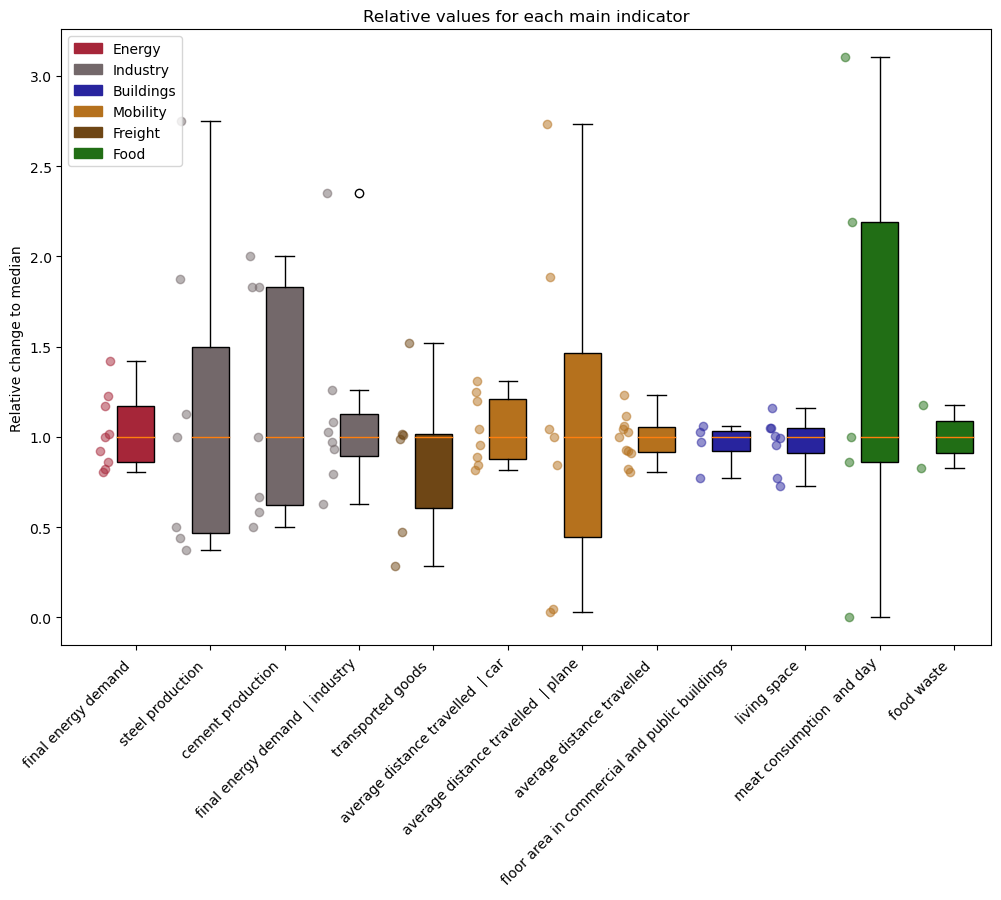

In [26]:
def make_boxplot(data, filename, extension = False, standard=False):
    '''
    Function to make a boxplot of the relative change to the median of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data

    # Get the main indicators
    main_indicators = get_main_indicators(analysis_standard_df)
    
    # Create Dataframe for the plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Sector', 'Color', 'Order'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector'].values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector'].apply(lambda x: colors_sector[x])
    main_indicators_plotting_df['Order'] =  main_indicators_plotting_df['Sector'].apply(lambda x: order_sectors[x])
    main_indicators_plotting_df = main_indicators_plotting_df.sort_values(by=['Order'], ascending=[True])
    main_indicators = main_indicators_plotting_df['Indicator'].values

    # Make a boxplot per Indicator
    # Calculate the Median for each Indicator and then the Percentage difference
    boxplot_data = {}
    indicator_table_data = pd.DataFrame()    

    # Iterate over the indicators and calculate the median and the difference to it
    for i, indicator in enumerate(main_indicators):

        # get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()

        # Get the values for the current indicator       
        indicator_values = indicator_data['Value']

        # Get the median
        indicator_median = indicator_values.median()
        
        # Add new columns for Median and Relative Change
        indicator_data['Median'] = indicator_median
        indicator_data['Relative Change'] = indicator_data['Value'] / indicator_median
        indicator_table_data = pd.concat([indicator_table_data, indicator_data])
        
        # Calculate the relative change to the median
        indicator_relative = indicator_values / indicator_median
        boxplot_data[indicator] = indicator_relative

    # Make a result Table for the Plot
    create_result_table_boxplot(indicator_table_data,  f'{filename}_table', ['Median', 'Relative Change'])

    # Make a boxplot for the indicator values
    fig, ax = plt.subplots(1, figsize=(12, 8))
    bplot = ax.boxplot(boxplot_data.values(), 
                    showfliers=True, 
                    patch_artist=True)

    # Add the datapoints as scatter
    for i, key in enumerate(boxplot_data.keys()):
        y = boxplot_data[key]
        x = np.random.normal(i+0.6, 0.04, size=len(y))
        color = main_indicators_plotting_df[main_indicators_plotting_df['Indicator'] == key]['Color'].values[0]
        ax.scatter(x, y, c=color, alpha=0.5)

    # Fill with colors according to the sector
    colors = [main_indicators_plotting_df[main_indicators_plotting_df['Indicator'] == key]['Color'].values[0] for key in boxplot_data.keys()]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # Configure the plot
    ax.set_title(f'Relative values for each main indicator')
    ax.set_ylabel('Relative change to median')
    naming_x_axis = [s.replace('per capita and year', '').replace('per capita', '') for s in boxplot_data.keys()] 
    ax.set_xticks(np.arange(start=1, stop=len(naming_x_axis)+1), naming_x_axis, rotation=45, ha="right")
    ax.set_xlim(0)

    # manually define a new patch for the legend
    patches = [mpatches.Patch(color=colors_sector[x], label=x) for x in colors_sector.keys()]

    # plot the legend
    ax.legend(handles=patches, loc='upper left')
    
    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    # Save the plot as png
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")

make_boxplot(analysis_df, 'boxplot_values')

##### 3.1.4 Make Boxplot of DLS

For each indicator where there is a DLS value, show the difference to this Value as a Boxplot

In [30]:
# Function gets the dls-values for and indicator for 
def get_dls(indicator, data):
    '''
    Function to get the DLS values for an indicator.
    :param indicator: Indicator to filter after
    :param data: Data from the Scenario Analysis sheet
    :return: Dataframe with only the DLS values
    '''
    # Get Data for the Hilward Hopkins et al. (2020) study
    data_hilward_hopkins = data[(data['Source'] == 'Millward-Hopkins et al. (2020)') & (data['Main comparison parameter'] == indicator)].copy()
    if len(data_hilward_hopkins) != 0:
        value_hilward_hopkins = float(data_hilward_hopkins['Value'].values[0])
    else:
        value_hilward_hopkins = np.nan
    return value_hilward_hopkins       

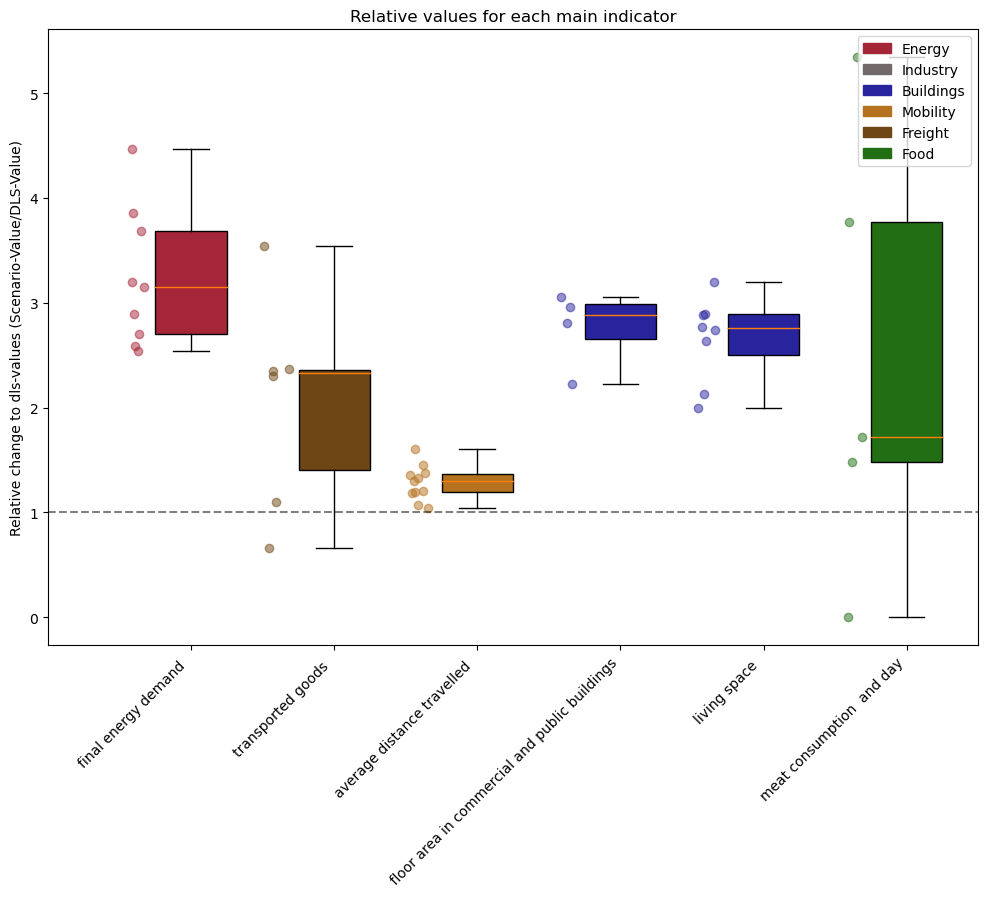

In [31]:
# Makes a boxplot showing the relative difference of scenario values to the dls values
def make_boxplot_dls(data, filename, extension = False, standard=False, raw_data=False):
    '''
    Function to make a boxplot of the relative change to the dls values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :param raw_data: Boolean if the raw data should be used instead of the filtered data
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data
        data = raw_data

    # Get the main indicators
    main_indicators = get_main_indicators(analysis_standard_df)

    # Create Dataframe for the plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Sector', 'Color', 'Order', 'DLS'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector'].values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector'].apply(lambda x: colors_sector[x])
    main_indicators_plotting_df['Order'] =  main_indicators_plotting_df['Sector'].apply(lambda x: order_sectors[x])
    main_indicators_plotting_df['DLS'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: get_dls(x, data))
    main_indicators_plotting_df = main_indicators_plotting_df.sort_values(by=['Order'])
    main_indicators_plotting_df = main_indicators_plotting_df.set_index('Indicator')
    main_indicators = main_indicators_plotting_df.index

    # Make a boxplot per Indicator
    # Calculate the Median for each Indicator and then the Percentage difference
    boxplot_data = {}
    indicator_table_data = pd.DataFrame()

    # Iterate over the indicators and calculate the median and the difference to it
    for i, indicator in enumerate(main_indicators):

        # get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()
        indicator_values = indicator_data['Value']

        # Get the median
        indicator_dls = main_indicators_plotting_df.at[indicator, 'DLS']

        if pd.isnull(indicator_dls):
            continue

        # Calculate the relative change to the median
        indicator_relative = indicator_values / indicator_dls

        # Add new columns for Median and Relative Change
        indicator_data['DLS'] = indicator_dls
        indicator_data['Relative Change'] = indicator_data['Value'] / indicator_dls
        indicator_table_data = pd.concat([indicator_table_data, indicator_data])

        boxplot_data[indicator] = indicator_relative

    # Creates a results table as excel containing all the datapoints
    create_result_table_boxplot(indicator_table_data,  f'{filename}_table', ['DLS', 'Relative Change'])

    # Make a boxplot for the indicator values
    fig, ax = plt.subplots(1, figsize=(12, 8))
    bplot = ax.boxplot(boxplot_data.values(), 
                    showfliers=True, 
                    patch_artist=True)

    # Add the datapoints as scatter
    for i, key in enumerate(boxplot_data.keys()):
        y = boxplot_data[key]
        x = np.random.normal(i+0.6, 0.04, size=len(y))
        color = main_indicators_plotting_df.at[key, 'Color']
        ax.scatter(x, y, c=color, alpha=0.5)

    # fill with colors
    colors = [main_indicators_plotting_df.at[key, 'Color'] for key in boxplot_data.keys()]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_title(f'Relative values for each main indicator')
    ax.set_ylabel('Relative change to dls-values (Scenario-Value/DLS-Value)')
    naming_x_axis = [s.replace('per capita and year', '').replace('per capita', '') for s in boxplot_data.keys()] 
    ax.set_xticks(np.arange(start=1, stop=len(naming_x_axis)+1), naming_x_axis, rotation=45, ha="right")
    ax.set_xlim(0)
    # Make a horizontal loine to show the 1 line (When value is 1, no change happened)
    ax.axhline(1, color='#030303', linestyle='--', alpha=0.5)

    # manually define a new patch 
    patches = [mpatches.Patch(color=colors_sector[x], label=x) for x in colors_sector.keys()]

    # plot the legend
    ax.legend(handles=patches, loc='upper right')

    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")

make_boxplot_dls(analysis_df, 'boxplot_dls')

##### 3.1.5 Make Boxplot Historic

For each indicator show the differences to the historic values.

In [28]:
# Get the historic data for one main indicator and study
def get_historic(row, data):
    '''
    Function to get the historic data for one main indicator and study.
    :param row: Row of the data
    :param data: Data from the Scenario Analysis sheet
    :return: Historic value
    '''
    # Get the historic data for the indicator
    historic_data = get_historic_data(data, row['Main comparison parameter'])

    # Get the source and scope of the study
    scenario = row['Source']
    scope = row['Geographic scope']

    # Check if a historic value for négaWatt is available
    if len(historic_data[(historic_data['Source'] == 'négaWatt et al. (2023)') & (historic_data['Geographic scope'] == scope)]):
        historic_value = historic_data[(historic_data['Source'] == 'négaWatt et al. (2023)') & (historic_data['Geographic scope'] == scope)]['Value'].values[0]

    # Else check if a historic value of the scenario is available
    elif len(historic_data[(historic_data['Source'] == scenario) & (historic_data['Geographic scope'] == scope)]):
        historic_value = historic_data[(historic_data['Source'] == scenario) & (historic_data['Geographic scope'] == scope)]['Value'].values[0]
    
    # Otherwise check if a historic value of the scope is available
    elif scope in historic_data['Geographic scope'].values:
        historic_value = historic_data[historic_data['Geographic scope'] == scope]['Value'].values[0]

    # Otherwise no historic value is available
    else:
        historic_value = np.nan

    return historic_value

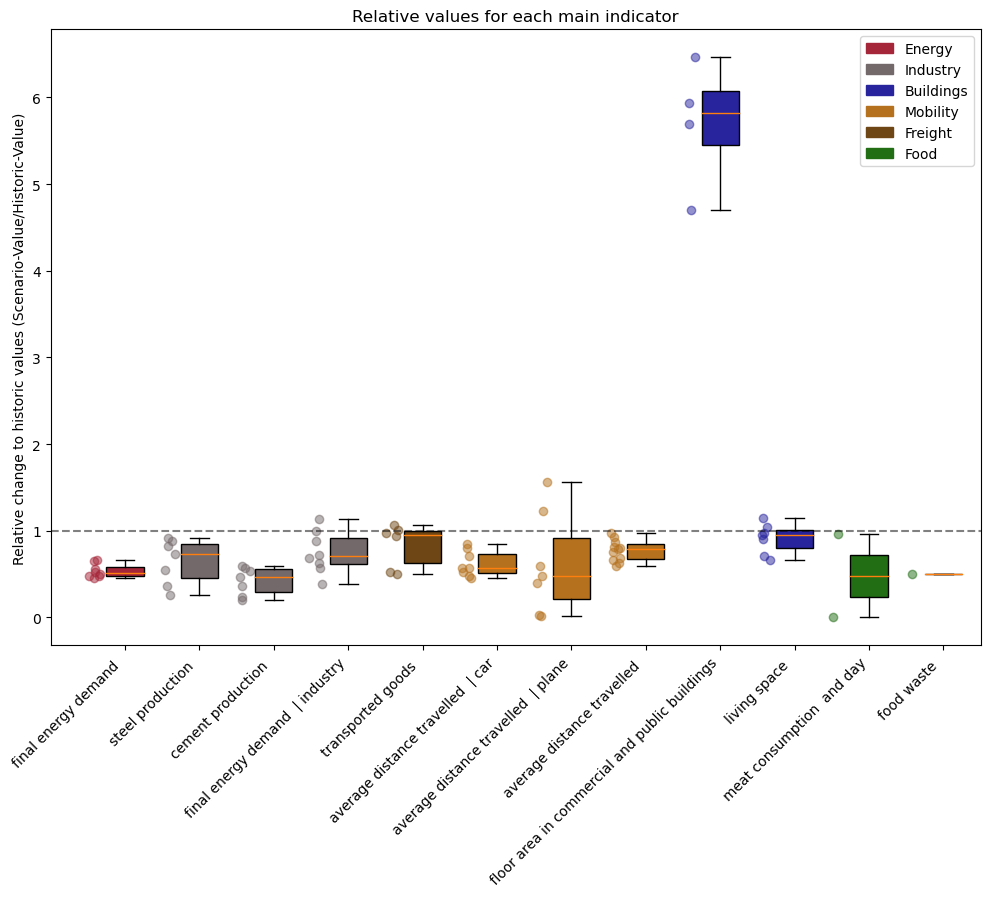

In [32]:
# Makes a boxplot showing the relative difference between each scenario and the corresponding historic value
def make_boxplot_historic(data, filename, extension = False, standard=False, raw_data=False):
    '''
    Function to make a boxplot of the relative change to the historic values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :param raw_data: Boolean if the raw data should be used instead of the filtered data
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data
        data = raw_data

    # Get the main indicators
    main_indicators = get_main_indicators(analysis_standard_df)

    # Create Dataframe for the plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Sector', 'Color', 'Order'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector'].values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector'].apply(lambda x: colors_sector[x])
    main_indicators_plotting_df['Order'] =  main_indicators_plotting_df['Sector'].apply(lambda x: order_sectors[x])
    main_indicators_plotting_df = main_indicators_plotting_df.sort_values(by=['Order'])
    main_indicators_plotting_df = main_indicators_plotting_df.set_index('Indicator')
    main_indicators = main_indicators_plotting_df.index

    # Make a boxplot per Indicator
    # Calculate the Median for each Indicator and then the Percentage difference
    boxplot_data = {}
    indicator_table_data = pd.DataFrame()

    # Iterate over the indicators and calculate the median and the difference to it
    for i, indicator in enumerate(main_indicators):

        # get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()
        indicator_data['Historic'] =  indicator_data.apply(lambda x: get_historic(x, data), axis=1)
        indicator_data = indicator_data.dropna(subset=['Historic'])
        indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
        indicator_data['Historic'] = pd.to_numeric(indicator_data['Historic'], errors='coerce')    
        indicator_values = indicator_data['Value']

        # Get the histroic Values
        indicator_historic = indicator_data['Historic']

        # Calculate the relative change to the historic value
        indicator_relative = indicator_values / indicator_historic
        boxplot_data[indicator] = indicator_relative

        indicator_data['Relative Change'] = indicator_data['Value'] / indicator_historic
        indicator_table_data = pd.concat([indicator_table_data, indicator_data])

    create_result_table_boxplot(indicator_table_data, f'{filename}_table', ['Historic', 'Relative Change'])

    # Make a boxplot for the indicator values
    fig, ax = plt.subplots(1, figsize=(12, 8))
    bplot = ax.boxplot(boxplot_data.values(), 
                    showfliers=True, 
                    patch_artist=True)

    # Add the datapoints as scatter
    for i, key in enumerate(boxplot_data.keys()):
        y = boxplot_data[key]
        x = np.random.normal(i+0.6, 0.04, size=len(y))
        color = main_indicators_plotting_df.at[key, 'Color']
        ax.scatter(x, y, c=color, alpha=0.5)

    # fill with colors
    colors = [main_indicators_plotting_df.at[key, 'Color'] for key in boxplot_data.keys()]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_title(f'Relative values for each main indicator')
    ax.set_ylabel('Relative change to historic values (Scenario-Value/Historic-Value)')
    naming_x_axis = [s.replace('per capita and year', '').replace('per capita', '') for s in boxplot_data.keys()] 
    ax.set_xticks(np.arange(start=1, stop=len(naming_x_axis)+1), naming_x_axis, rotation=45, ha="right")
    ax.set_xlim(0)

    # Make a horizontal loine to show the 1 line (When value is 1, no change happened)
    ax.axhline(1, color='#030303', linestyle='--', alpha=0.5)

    # manually define a new patch 
    patches = [mpatches.Patch(color=colors_sector[x], label=x) for x in colors_sector.keys()]

    # plot the legend
    ax.legend(handles=patches, loc='upper right')

    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")

make_boxplot_historic(analysis_df, 'boxplot_historic')

##### 3.1.5´6 Make a scatter plot

This plot shows for each indicator a scatter plot, where the scenario valus is shown over the historic value.

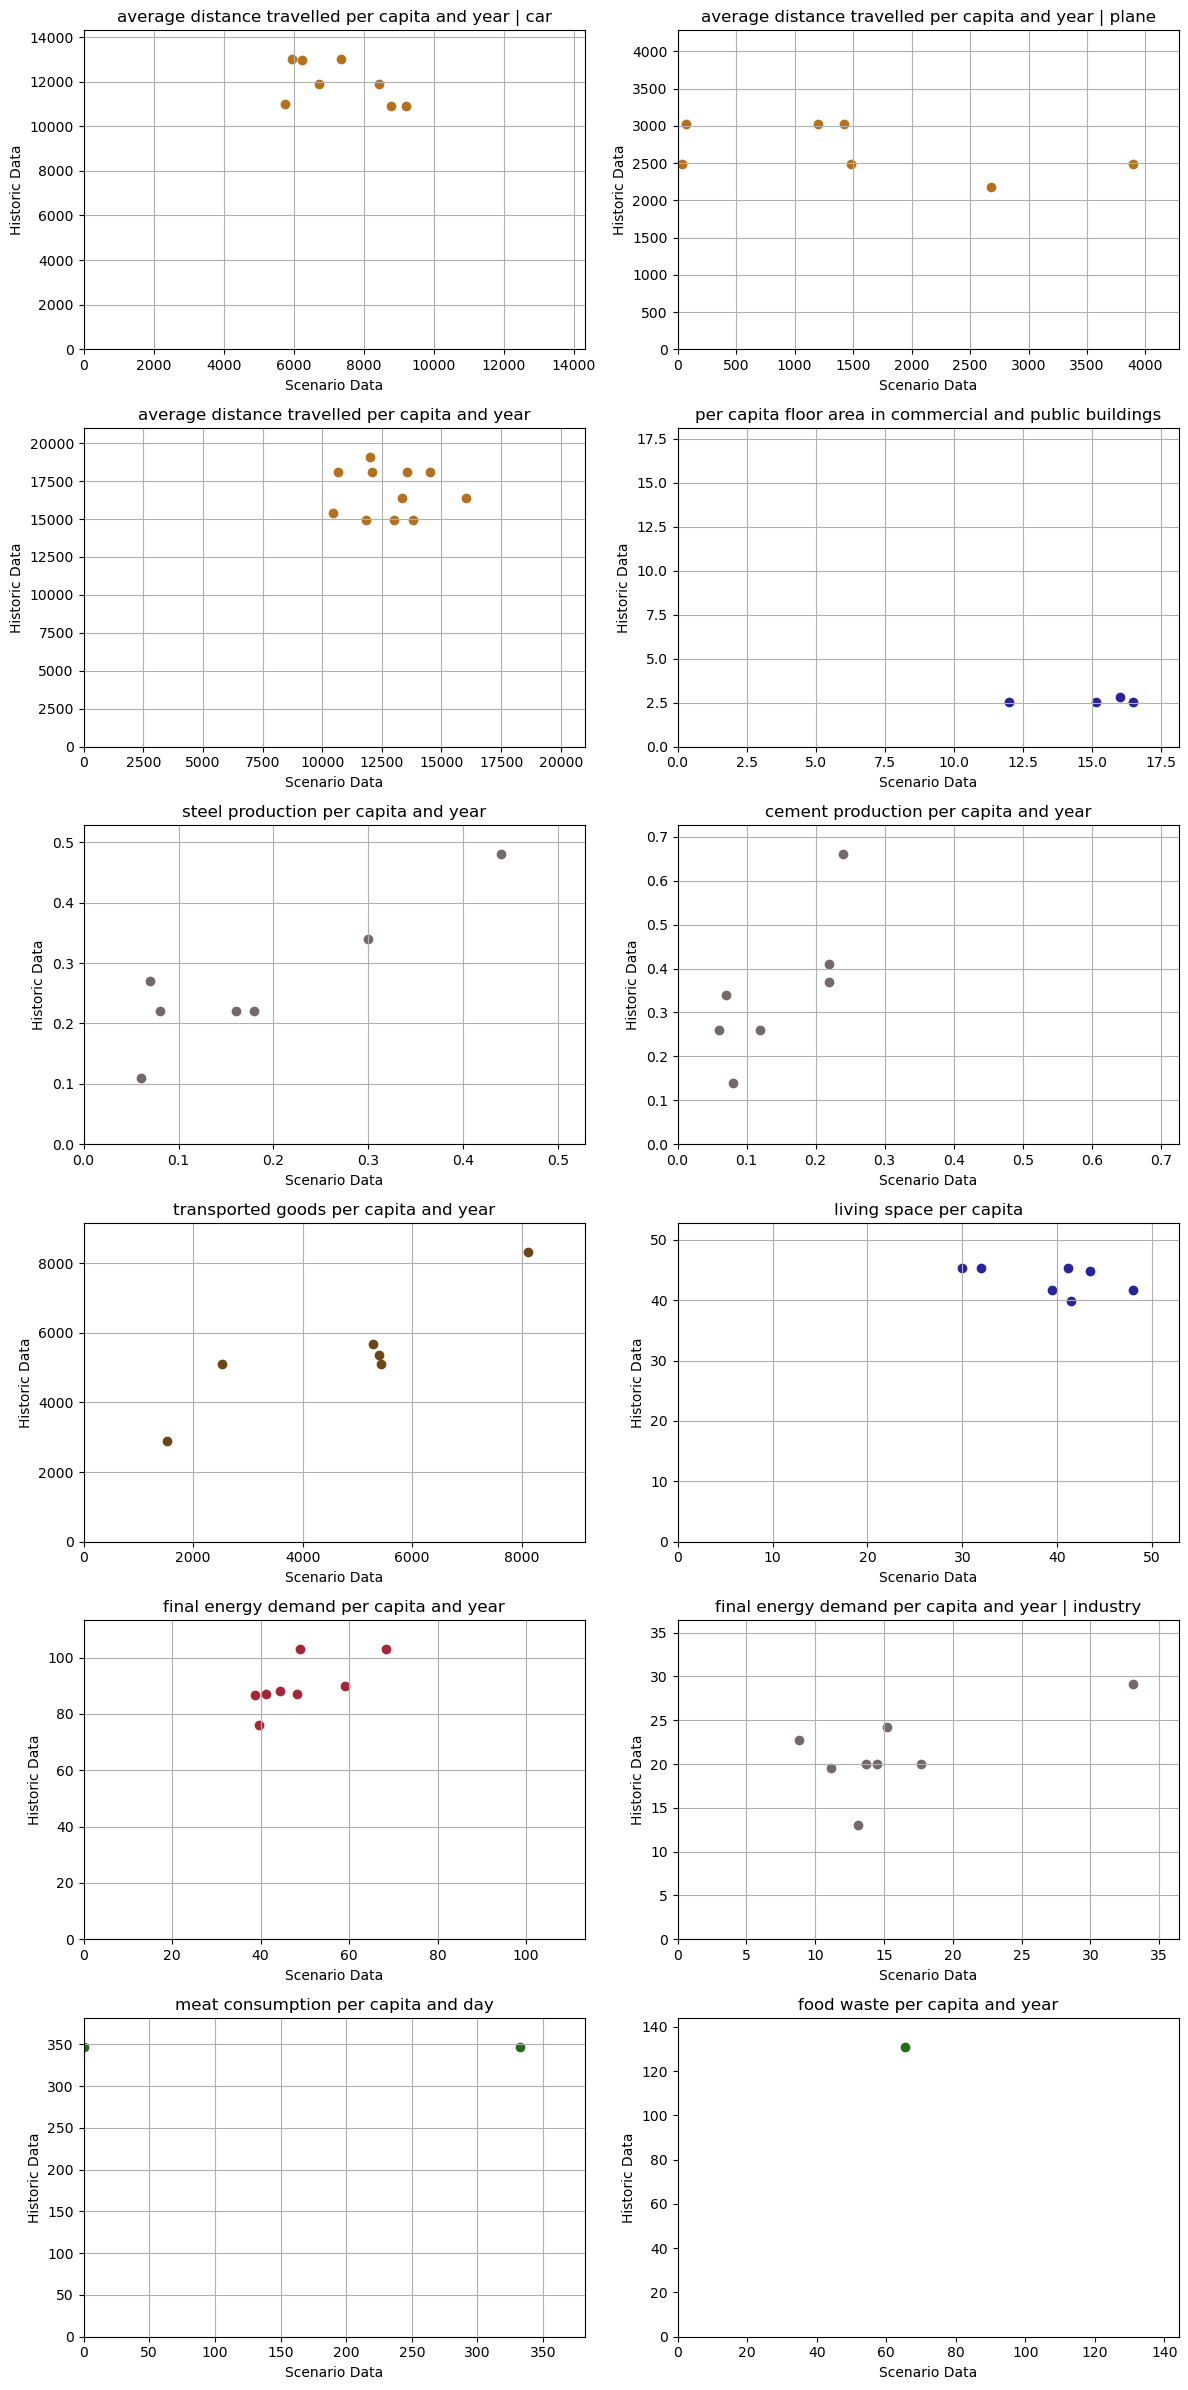

In [36]:
# Makes a scatter plot per indicator showing the scenario value over the historic value
def make_scatter_plot(data, filename, extension = False, standard=False):
    '''
    Function to make a scatter plot of the scenario values over the historic values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :return: None
    '''
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data

    main_indicators = get_main_indicators(analysis_standard_df)

    historic_data = get_historic_data(data)

    # Create Dataframe for the plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Sector', 'Color', 'Order', 'DLS'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector'].values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector'].apply(lambda x: colors_sector[x])
    main_indicators_plotting_df = main_indicators_plotting_df.set_index('Indicator')
    # Define number of columns for the subplots
    cols = 2
    rows = len(main_indicators) // cols

    # Create a figure of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(12,24))

    # Iterate over the indicators and make a plot for each índicator
    for i, indicator in enumerate(main_indicators):
        
        # Calculate current row and column 
        row = i // cols
        col = i % cols
        ax = axs[row, col]

        # Get indicator data
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()
        indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
        # indicator_data['Color'] = indicator_data['Geographic scope'].apply(lambda x: scope_colors[x] if x in scope_colors.keys() else scope_colors['single'])
        # indicator_data['Label'] = indicator_data['Geographic scope'].apply(lambda x: x if x in scope_colors.keys() else 'single')
        indicator_data = indicator_data.sort_values('Value')

        # Get the sector of the indicator
        sector = main_indicators_plotting_df.at[indicator, 'Sector']

        # Get the historic data
        historic_data = get_historic_data(analysis_df, indicator)
        historic_plots = []
        drop_indices = []
        # Get for each scenario the corresponding historic value
        for index, row in indicator_data.iterrows():
            scenario = row['Source']
            scope = row['Geographic scope']
            # Check if a historic value for négaWatt is available
            if len(historic_data[(historic_data['Source'] == 'négaWatt et al. (2023)') & (historic_data['Geographic scope'] == scope)]):
                historic_value = historic_data[(historic_data['Source'] == 'négaWatt et al. (2023)') & (historic_data['Geographic scope'] == scope)]['Value'].values[0]
                historic_plots.append(historic_value)

            # Else check if a historic value of the scenario is available
            elif len(historic_data[(historic_data['Source'] == scenario) & (historic_data['Geographic scope'] == scope)]):
                historic_value = historic_data[(historic_data['Source'] == scenario) & (historic_data['Geographic scope'] == scope)]['Value'].values[0]
                historic_plots.append(historic_value)     

            # Otherwise check if a historic value of the scope is available
            elif scope in historic_data['Geographic scope'].values:
                historic_value = historic_data[historic_data['Geographic scope'] == scope]['Value'].values[0]
                historic_plots.append(historic_value)
            
            # Otherwise no historic value is available
            else:
                drop_indices.append(index)
            
        # Drop rows where no historic value exists
        indicator_data = indicator_data.drop(index=drop_indices)

        # Get values for plotting
        scenario_values = indicator_data['Value'].values
        
        # Convert to numeric
        historic_values = pd.to_numeric(historic_plots)
        
        # Get the maximum value for the plot
        if len(scenario_values) != 0:
            max_value = max(max(scenario_values), max(historic_values))
        else:
            max_value = 1

        # Plot the scatter plot
        ax.scatter(scenario_values, historic_values, color=colors_sector[sector])

        # configure plot
        ax.set_title(indicator)
        ax.set_xlabel('Scenario Data')
        ax.set_ylabel('Historic Data')
        ax.set_ylim(0, max_value*1.1)
        ax.set_xlim(0, max_value*1.1)

        # Add a grid
        ax.grid()
    
    # Make a nicer look
    plt.tight_layout()
    
    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}', bbox_inches = 'tight')

make_scatter_plot(analysis_df, 'scatterplot')      

#### 3.2 Germany specific plots

Make all the plots from before for the studies where the scope is only Germany.

##### 3.2.1 Get German data
First we select the data where the scope is germany. Then we use the functions from before to create plots for Germany.

In [38]:
# Filter for standard scenarios
standard_scenarios = scenarios_df[scenarios_df['germany'] == 1]

# Get the data for the standard scenarios for Germany
standard_scenarios_data = standard_scenarios.apply(lambda x: analysis_df[(analysis_df['Source'] == x['Source']) \
                                                                        & (analysis_df['Scenario (name/historic/DLS)'] == x['scenarios']) \
                                                                        & (analysis_df['Geographic scope'] == 'DE')].index.values, axis=1).explode().dropna()
scenario_analysis_germany_df = analysis_df.loc[standard_scenarios_data]
scenario_analysis_germany_df['Geographic scope'] = scenario_analysis_germany_df['Geographic scope'].str.replace(' ', '')

# Filter for coding 1
scenario_analysis_germany_df = scenario_analysis_germany_df[scenario_analysis_germany_df['Coding'] == 1]

# Remove kcal Data
scenario_analysis_germany_df = scenario_analysis_germany_df[~scenario_analysis_germany_df['Unit'].str.contains('kcal')]

##### 3.2.1 Make the plots
We make use of the functions defined above to make the plots for Germany

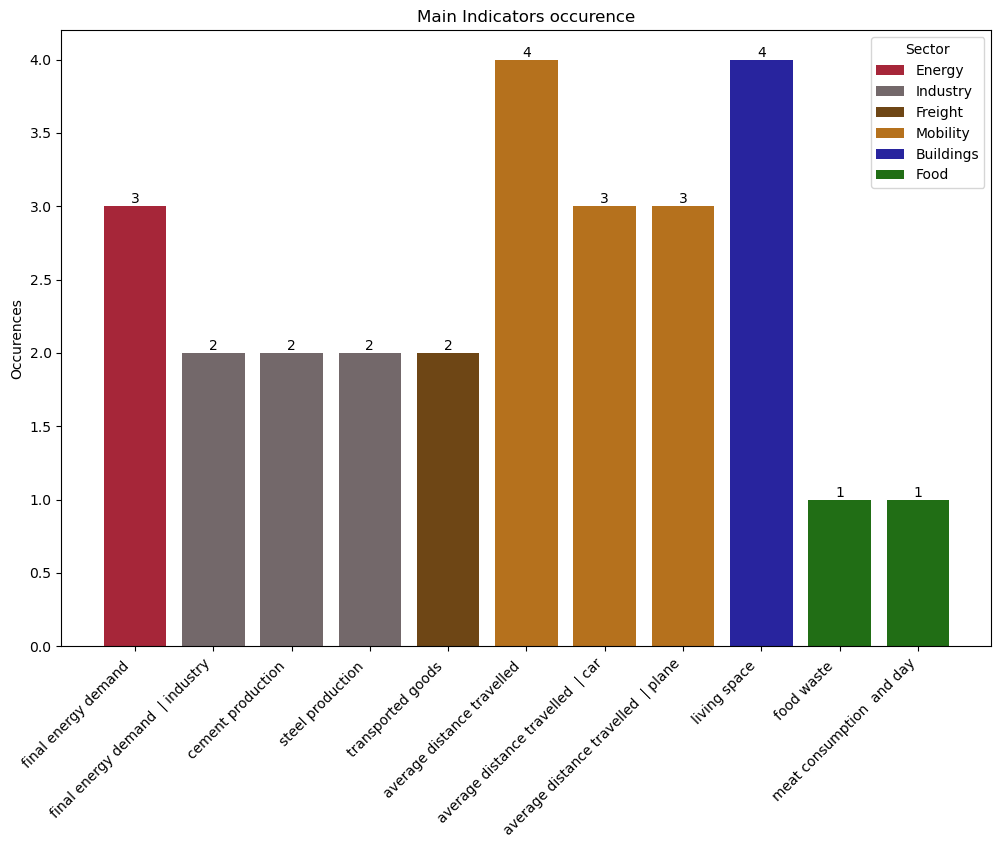

In [39]:
make_barplot_occurences(scenario_analysis_germany_df, 'barplot_occurences_germany', standard=True)

C:\Users\yanni\AppData\Local\Temp\ipykernel_28704\4020170066.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'négaWatt et al. (2023)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  indicator_data.at[index, 'Historic Source'] = source
C:\Users\yanni\AppData\Local\Temp\ipykernel_28704\4020170066.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'final energy demand per capita' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  indicator_data.at[index, 'Historic Parameter'] = historic_parameter
C:\Users\yanni\AppData\Local\Temp\ipykernel_28704\4020170066.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'négaWatt et al. (2023)' has dtype incompatible with float64, please explicitly cast

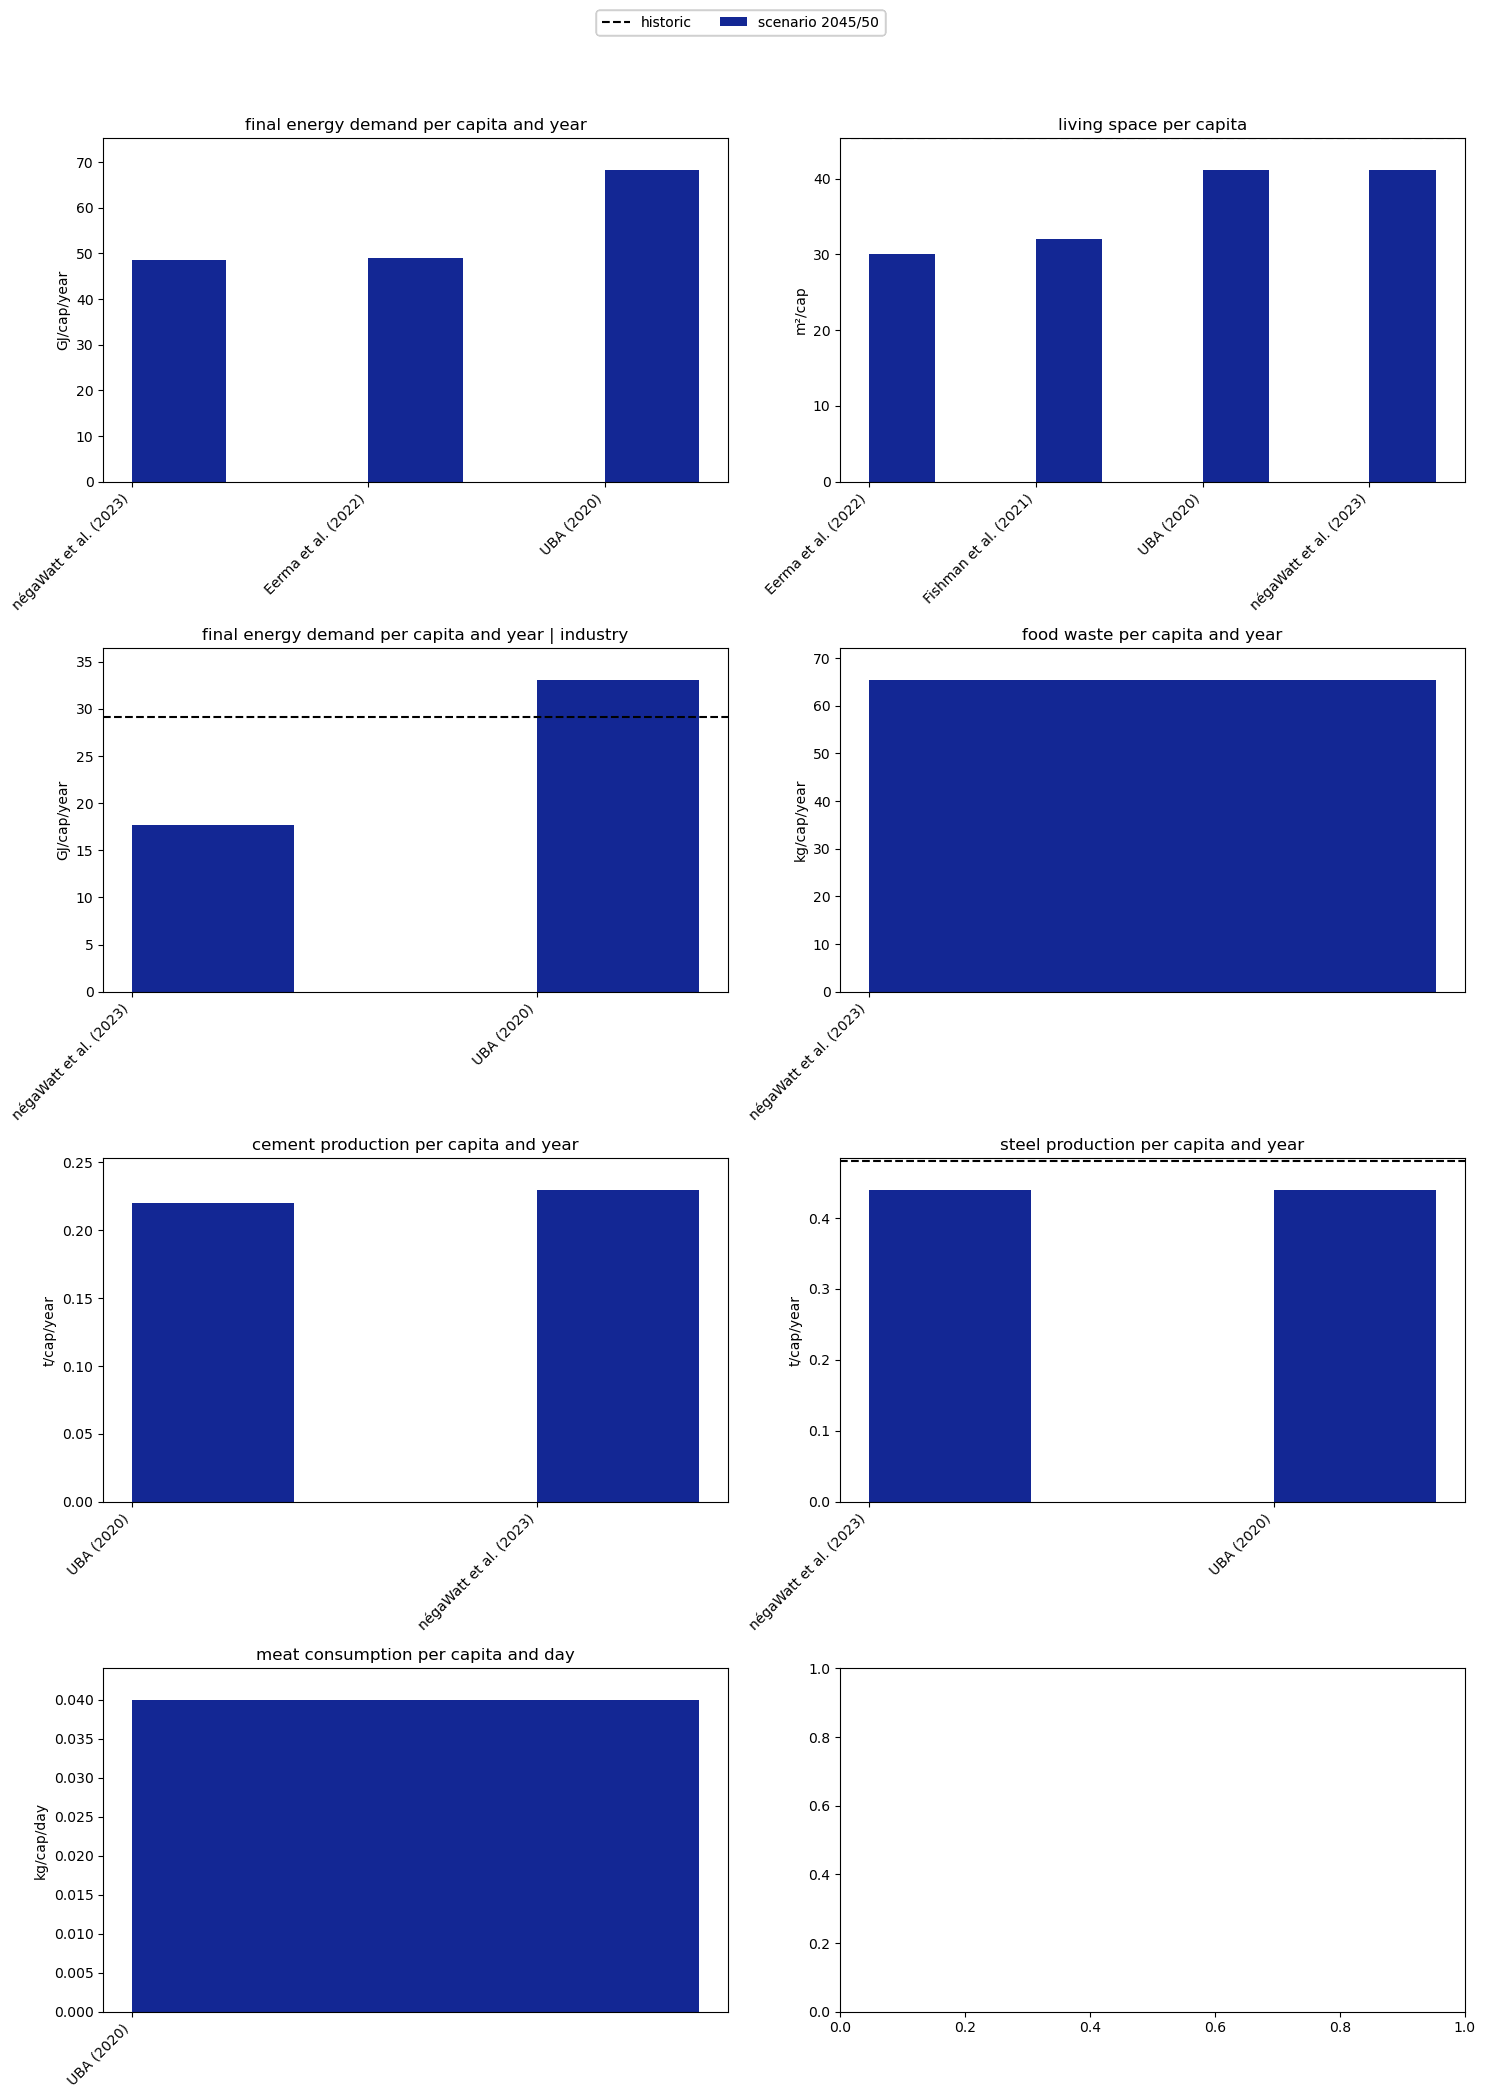

In [40]:
make_barplot_multiple(scenario_analysis_germany_df, 'barplot_values_germany', 
                      standard=True, show_extra_bars=False, show_scope = False, show_historic=False)

C:\Users\yanni\AppData\Local\Temp\ipykernel_28704\4020170066.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'négaWatt et al. (2023)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  indicator_data.at[index, 'Historic Source'] = source
C:\Users\yanni\AppData\Local\Temp\ipykernel_28704\4020170066.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Passenger km per capita on road' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  indicator_data.at[index, 'Historic Parameter'] = historic_parameter
C:\Users\yanni\AppData\Local\Temp\ipykernel_28704\4020170066.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'négaWatt et al. (2023)' has dtype incompatible with float64, please explicitly cas

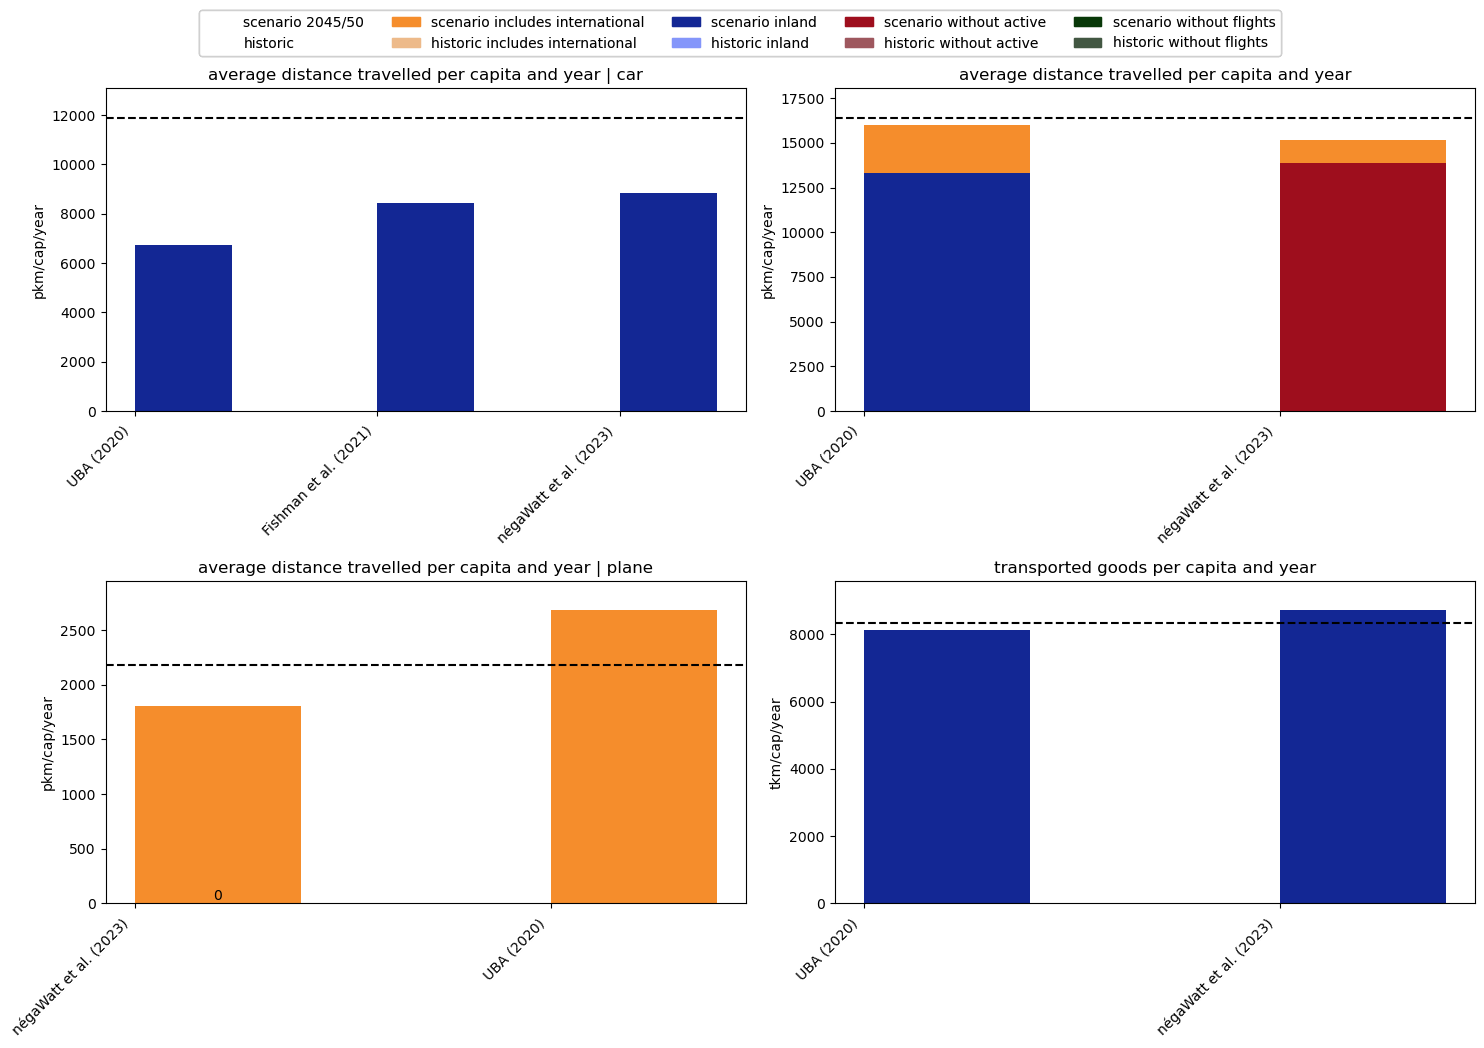

In [49]:
make_traffic_plots(scenario_analysis_germany_df, 'barplot_values_germany', 
                      standard=True, show_extra_bars=False, show_scope = False, show_historic=False)

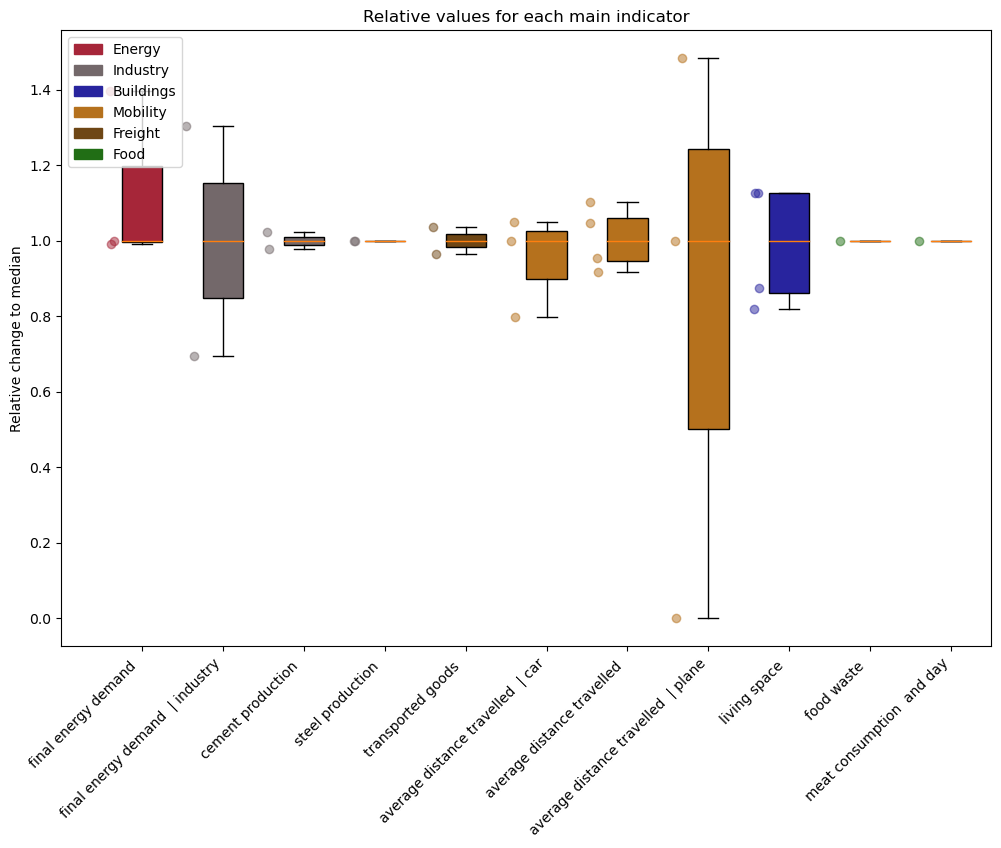

In [ ]:
make_boxplot(scenario_analysis_germany_df, 'boxplot_germany', standard=True)

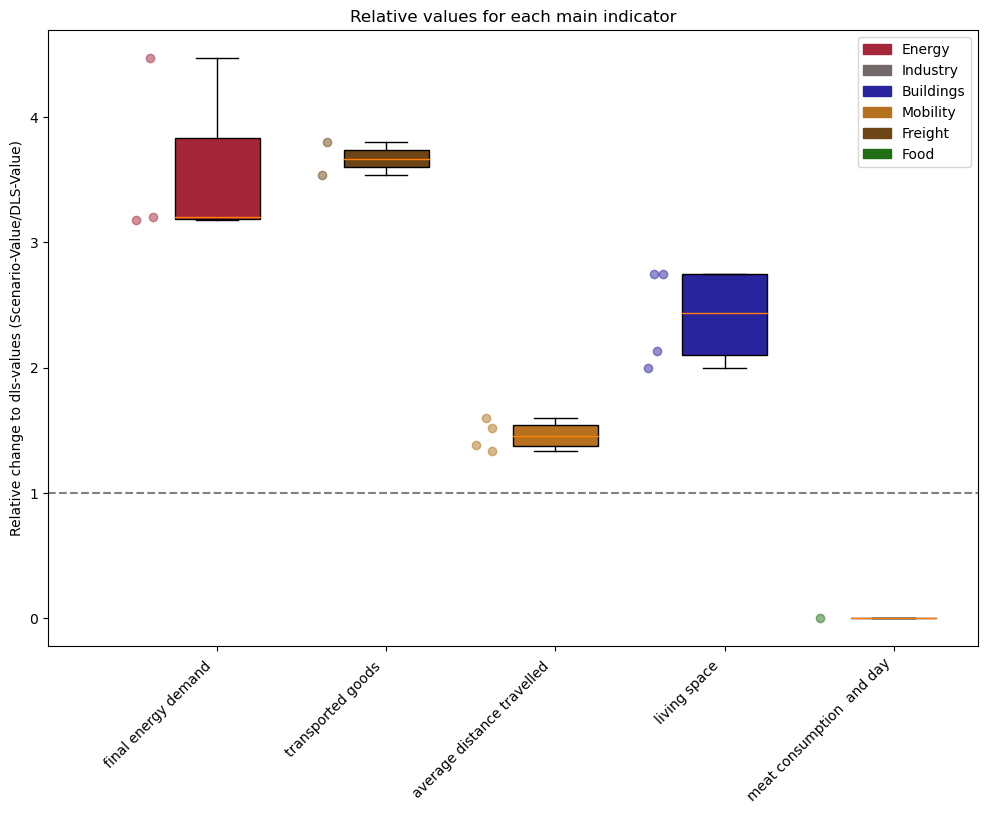

In [42]:
make_boxplot_dls(scenario_analysis_germany_df, 'boxplot_germany_dls', standard=True, raw_data=analysis_df)

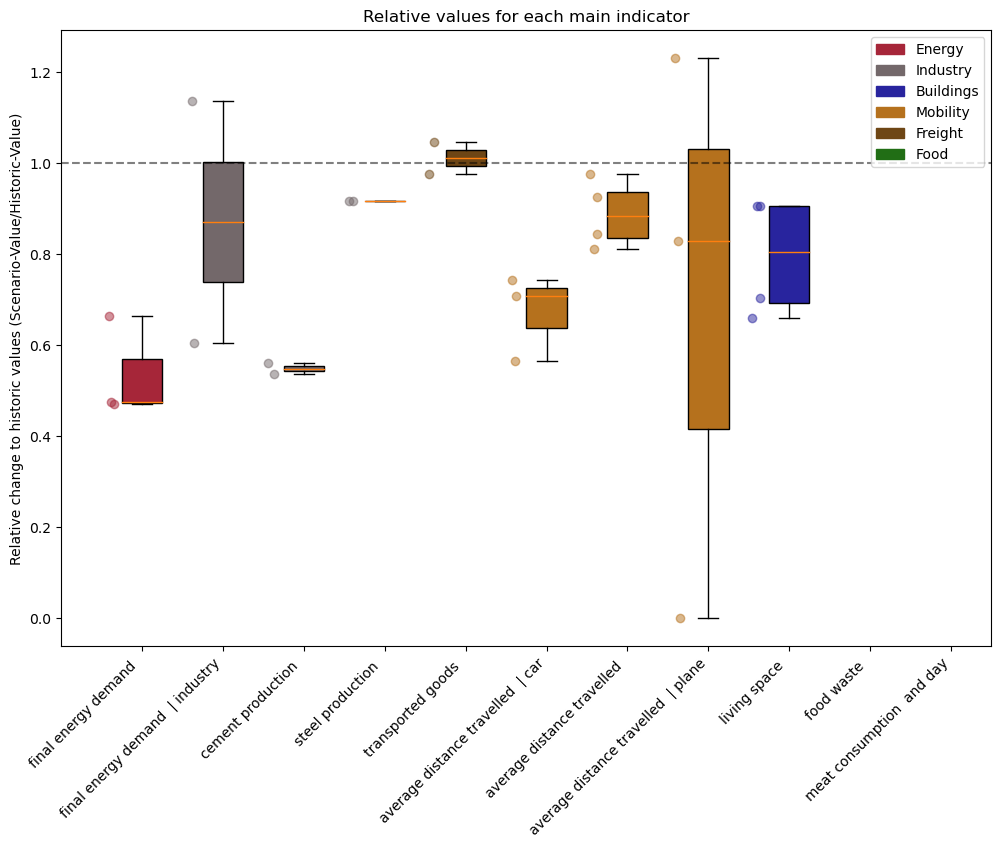

In [43]:
make_boxplot_historic(scenario_analysis_germany_df, 'boxplot_germany_historic', standard=True, raw_data=analysis_df)